# Hero FinCorp — Colab Notebook


In [80]:
# -------------------------
# 1. Environment & Imports
# -------------------------
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling / Stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Utility
import datetime as dt


In [81]:
# -------------------------
# 2. Mount Google Drive (Colab)
# -------------------------
from google.colab import drive

drive.mount('/content/drive')

# The folder:
# https://drive.google.com/drive/folders/1nbqH-nccC8jPJ1_fEBqc_uV0PDnHJoK7

DATA_DIR = '/content/drive/MyDrive/HeroFin_Data'

# fallback if you manually upload CSVs
LOCAL_FALLBACK = '/content'

# helper to resolve path
def resolve_path(filename):
    p_drive = Path(DATA_DIR) / filename
    p_local = Path(LOCAL_FALLBACK) / filename
    if p_drive.exists():
        return str(p_drive)
    if p_local.exists():
        return str(p_local)
    raise FileNotFoundError(f"{filename} not found in DATA_DIR or LOCAL_FALLBACK.\nPlease upload or adjust DATA_DIR.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# -------------------------
# 3. Load datasets
# -------------------------
FILES = {
    'customers': 'customers.csv',
    'loans': 'loans.csv',
    'applications': 'applications.csv',
    'transactions': 'transactions.csv',
    'defaults': 'defaults.csv',
    'branches': 'branches.csv'
}

dfs = {}
for key, fname in FILES.items():
    try:
        path = resolve_path(fname)
        print(f'Loading {key} from', path)
        dfs[key] = pd.read_csv(path)
    except Exception as e:
        print(f'Could not load {fname}:', e)
        dfs[key] = None

# Quick peek
for k, df in dfs.items():
    if df is None:
        continue
    print('\n----', k, 'shape:', df.shape)
    display(df.head(2))


Loading customers from /content/drive/MyDrive/HeroFin_Data/customers.csv
Loading loans from /content/drive/MyDrive/HeroFin_Data/loans.csv
Loading applications from /content/drive/MyDrive/HeroFin_Data/applications.csv
Loading transactions from /content/drive/MyDrive/HeroFin_Data/transactions.csv
Loading defaults from /content/drive/MyDrive/HeroFin_Data/defaults.csv
Loading branches from /content/drive/MyDrive/HeroFin_Data/branches.csv

---- customers shape: (70000, 14)


,Customer_ID,Full_Name,Contact_Number,Email,Address,Age,Gender,Marital_Status,Employment_Status,Annual_Income,Credit_Score,Region,Account_Tenure,Relationship_Manager_ID
0,C000001,Shayak Kumar,1549750578,saxenaindrans@gopal-krishnan.com,"27/062\nSangha Nagar, Bongaigaon 736150",53,Male,Single,Unemployed,886810,433,North,12 Years,RM0015
1,C000002,Divij Ghosh,2121540709,ramanindranil@tella.com,"H.No. 20, Edwin Circle\nKatihar 892167",62,Female,Single,Self-Employed,396746,418,West,10 Years,RM0276



---- loans shape: (90000, 12)


,Loan_ID,Customer_ID,Loan_Amount,Interest_Rate,Loan_Term,Disbursal_Date,Repayment_Start_Date,Repayment_End_Date,Loan_Status,Overdue_Amount,EMI_Amount,Collateral_Details
0,L000001,C045929,4030468,8.45,24,2023-03-25,2023-04-25,2025-03-25,Active,0,18668,Property
1,L000002,C038991,3498647,11.90,48,2023-10-23,2023-11-23,2027-10-23,Closed,44003,36012,Property



---- applications shape: (82600, 10)


,Application_ID,Loan_ID,Customer_ID,Application_Date,Approval_Date,Loan_Purpose,Source_Channel,Processing_Fee,Approval_Status,Rejection_Reason
0,A000001,L000001,C000001,2022-05-11,2020-10-02,Business,Agent,6427,Approved,NaN
1,A000002,L000002,C000002,2022-03-18,2022-11-29,Education,Online,8605,Approved,NaN



---- transactions shape: (495000, 9)


,Transaction_ID,Loan_ID,Customer_ID,Transaction_Date,Payment_Type,Amount,Overdue_Fee,Remaining_Balance,Mode_of_Payment
0,T00000001,L005588,C050792,2021-04-30,EMI,46099,1313,1513669,NEFT
1,T00000002,L019942,C008919,2021-12-14,Penalty,43648,4852,901455,UPI



---- defaults shape: (9000, 9)


,Default_ID,Loan_ID,Customer_ID,Default_Date,Default_Amount,Default_Reason,Recovery_Status,Recovery_Amount,Legal_Action
0,D000001,L007312,C007312,2022-07-20,94480,Job Loss,Full,30360,Yes
1,D000002,L028234,C028234,2023-09-23,10912,Job Loss,Partial,0,Yes



---- branches shape: (50, 9)


,Branch_ID,Branch_Name,Region,Total_Customers,Total_Active_Loans,Delinquent_Loans,Loan_Disbursement_Amount,Avg_Processing_Time,Relationship_Manager_Count
0,B001,"Dhar, Kant and Madan",West,2891,279,21,341680882,6,29
1,B002,Shan Group,East,4459,1201,149,96549019,8,35


In [83]:
# -------------------------
# Task 1. Data Quality & Preparation
# -------------------------

def basic_overview(df, name='df'):
    print(f"== {name} overview ==")
    print('shape:', df.shape)
    print('\nMissing per column:')
    print(df.isnull().sum())
    print('\nDtypes:')
    print(df.dtypes)
    print('\nDuplicates:', df.duplicated().sum())


def standardize_dates(df, date_cols):
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df


def fill_or_flag_missing(df):
    for c in df.columns:
        if df[c].isnull().sum() == 0:
            continue
        df[c + '_missing_flag'] = df[c].isnull().astype(int)
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c].fillna(df[c].median(), inplace=True)
        else:
            df[c].fillna('Unknown', inplace=True)
    return df


def detect_and_cap_outliers(df, cols, factor=1.5):
    for col in cols:
        if col not in df.columns:
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply basic cleaning to each loaded DF
# Define likely date columns (adjust if your CSV uses different names)
customers_date_cols = ['Date_of_Birth', 'Customer_Since']
applications_date_cols = ['Application_Date']
loans_date_cols = ['Disbursement_Date', 'Maturity_Date', 'Approval_Date']
transactions_date_cols = ['Transaction_Date']
defaults_date_cols = ['Default_Date']

for name, df in dfs.items():
    if df is None:
        continue
    print('\n-- Overview for', name)
    basic_overview(df, name=name)

# Standardize dates
if dfs['customers'] is not None:
    dfs['customers'] = standardize_dates(dfs['customers'], customers_date_cols)
if dfs['applications'] is not None:
    dfs['applications'] = standardize_dates(dfs['applications'], applications_date_cols)
if dfs['loans'] is not None:
    dfs['loans'] = standardize_dates(dfs['loans'], loans_date_cols)
if dfs['transactions'] is not None:
    dfs['transactions'] = standardize_dates(dfs['transactions'], transactions_date_cols)
if dfs['defaults'] is not None:
    dfs['defaults'] = standardize_dates(dfs['defaults'], defaults_date_cols)

# Fill and flag missing
for k in dfs:
    if dfs[k] is not None:
        dfs[k] = fill_or_flag_missing(dfs[k])

# Cap numeric outliers (common numeric columns)
numeric_cols_to_cap = ['Loan_Amount','Interest_Rate','Default_Amount','Transaction_Amount','Annual_Income']
for k in dfs:
    if dfs[k] is not None:
        dfs[k] = detect_and_cap_outliers(dfs[k], numeric_cols_to_cap)


-- Overview for customers
== customers overview ==
shape: (70000, 14)

Missing per column:
Customer_ID                0
Full_Name                  0
Contact_Number             0
Email                      0
Address                    0
Age                        0
Gender                     0
Marital_Status             0
Employment_Status          0
Annual_Income              0
Credit_Score               0
Region                     0
Account_Tenure             0
Relationship_Manager_ID    0
dtype: int64

Dtypes:
Customer_ID                object
Full_Name                  object
Contact_Number              int64
Email                      object
Address                    object
Age                         int64
Gender                     object
Marital_Status             object
Employment_Status          object
Annual_Income               int64
Credit_Score                int64
Region                     object
Account_Tenure             object
Relationship_Manager_ID    object
dtyp

In [84]:
# -------------------------
# Task 1.1 Merge datasets
# -------------------------
# Merge loans with customers, branches, and defaults
loans_enriched = None
if dfs['loans'] is not None:
    loans_enriched = dfs['loans'].copy()
    # merge customer
    if dfs['customers'] is not None and 'Customer_ID' in loans_enriched.columns and 'Customer_ID' in dfs['customers'].columns:
        loans_enriched = loans_enriched.merge(dfs['customers'], on='Customer_ID', how='left', suffixes=('', '_cust'))
    # merge branch
    if dfs['branches'] is not None and 'Branch_ID' in loans_enriched.columns and 'Branch_ID' in dfs['branches'].columns:
        loans_enriched = loans_enriched.merge(dfs['branches'], on='Branch_ID', how='left', suffixes=('', '_branch'))
    # mark default flag
    if dfs['defaults'] is not None and 'Loan_ID' in dfs['defaults'].columns:
        loans_enriched['Default_Flag'] = loans_enriched['Loan_ID'].isin(dfs['defaults']['Loan_ID']).astype(int)
    else:
        loans_enriched['Default_Flag'] = 0
    print('Loans enriched shape:', loans_enriched.shape)
    display(loans_enriched.head(3))

Loans enriched shape: (90000, 27)


,Loan_ID,Customer_ID,Loan_Amount,Interest_Rate,Loan_Term,Disbursal_Date,Repayment_Start_Date,Repayment_End_Date,Loan_Status,Overdue_Amount,...,Age,Gender,Marital_Status,Employment_Status,Annual_Income,Credit_Score,Region,Account_Tenure,Relationship_Manager_ID,Default_Flag
0,L000001,C045929,4030468.0,8.45,24,2023-03-25,2023-04-25,2025-03-25,Active,0,...,60,Male,Divorced,Unemployed,634102.0,343,East,3 Years,RM0150,0
1,L000002,C038991,3498647.0,11.90,48,2023-10-23,2023-11-23,2027-10-23,Closed,44003,...,42,Other,Single,Salaried,957347.0,589,North,11 Years,RM0082,0
2,L000003,C046662,4871438.0,9.74,24,2024-07-30,2024-08-30,2026-07-30,Overdue,0,...,55,Female,Married,Salaried,644217.0,832,East,2 Years,RM0296,0


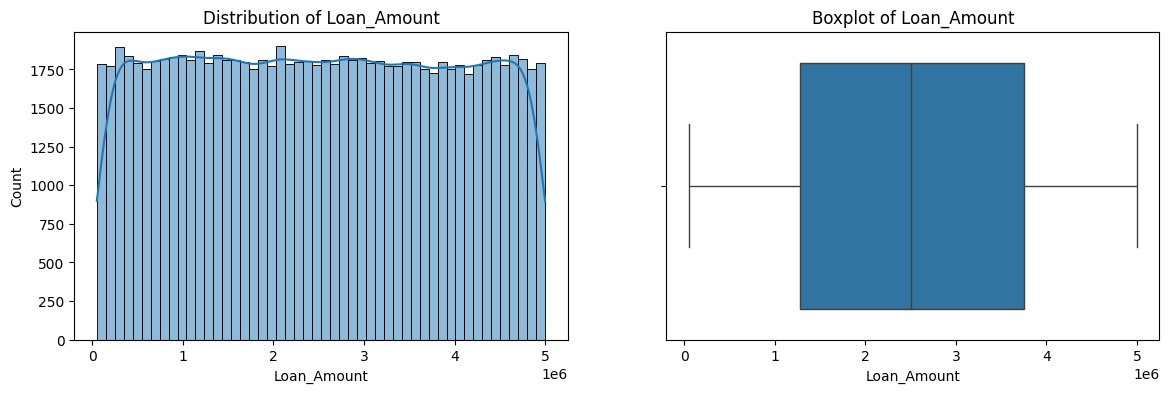

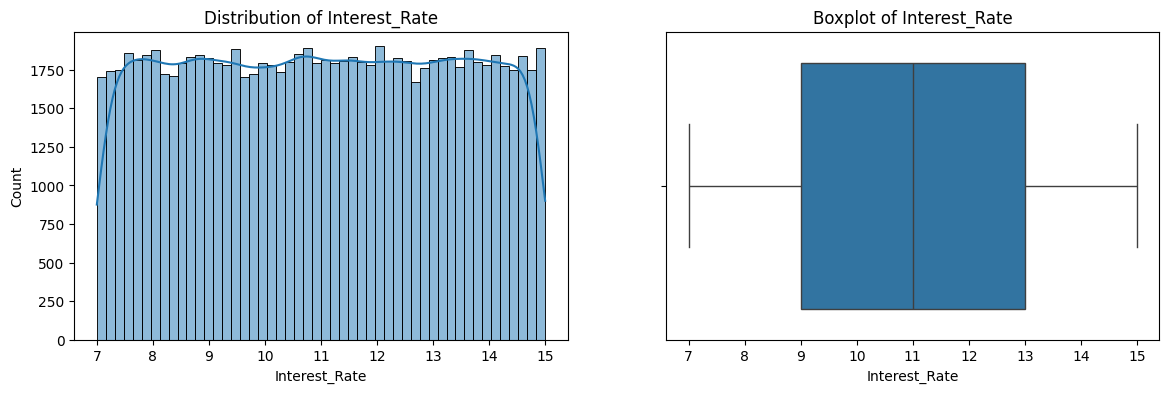

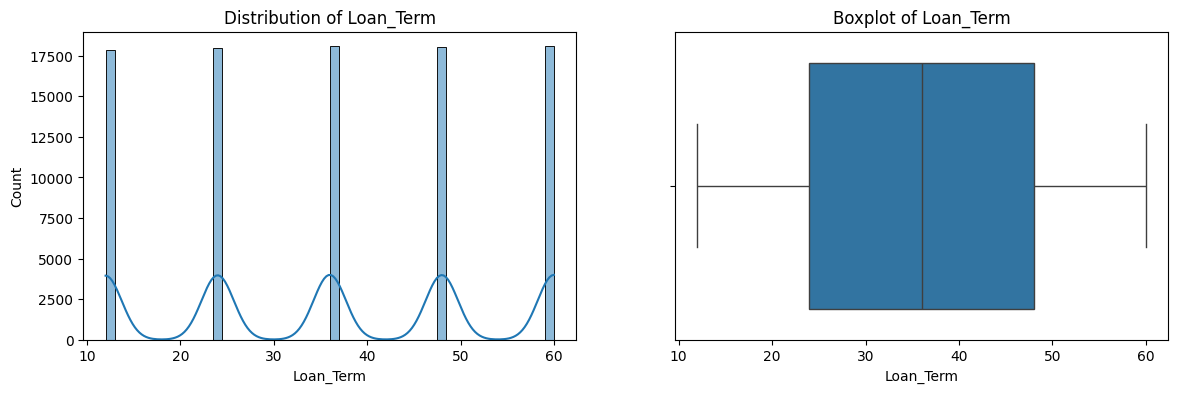

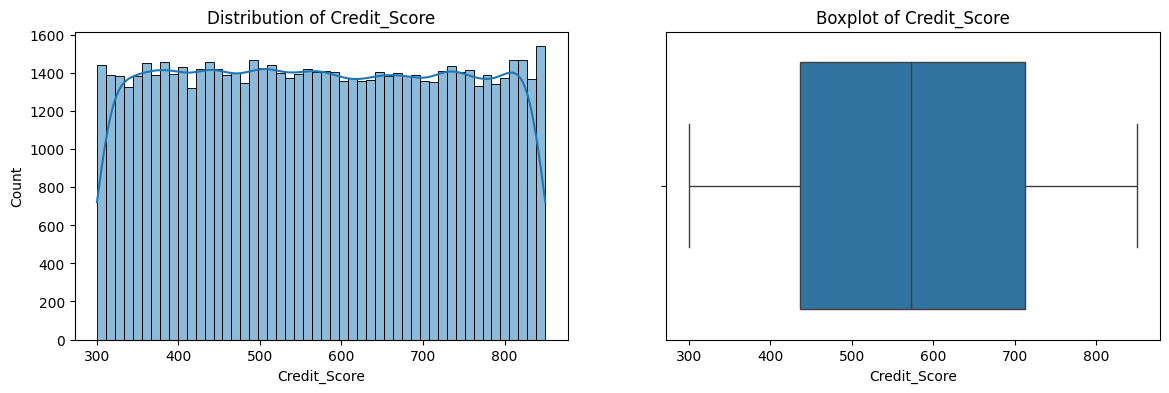

,total_disbursed,n_loans
Region,,
East,3.843780e+10,15316
North,3.796395e+10,15041
South,3.774057e+10,14949
West,3.760016e+10,14901
Northeast,3.747736e+10,14944
Central,3.724344e+10,14849


In [85]:
# -------------------------
# Task2. Descriptive Analysis
# -------------------------

def plot_dist_and_box(df, col, bins=50):
    if col not in df.columns:
        print(col, 'not found')
        return
    fig, axes = plt.subplots(1,2,figsize=(14,4))
    sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    sns.boxplot(x=df[col].dropna(), ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.show()

if loans_enriched is not None:
    for c in ['Loan_Amount','Interest_Rate','Loan_Term']:
        plot_dist_and_box(loans_enriched, c)
if dfs['customers'] is not None:
    plot_dist_and_box(dfs['customers'], 'Credit_Score')

# Regional trends: disbursement by region
if loans_enriched is not None and 'Region' in loans_enriched.columns:
    reg = loans_enriched.groupby('Region').agg(total_disbursed=('Loan_Amount','sum'), n_loans=('Loan_ID','nunique'))
    display(reg.sort_values('total_disbursed', ascending=False))

# Monthly trends in loan disbursement
if loans_enriched is not None and 'Disbursement_Date' in loans_enriched.columns:
    loans_enriched['disb_month'] = loans_enriched['Disbursement_Date'].dt.to_period('M')
    monthly = loans_enriched.groupby('disb_month').agg(total_disbursed=('Loan_Amount','sum'), n_loans=('Loan_ID','nunique')).reset_index()
    monthly['disb_month'] = monthly['disb_month'].dt.to_timestamp()
    fig = px.line(monthly, x='disb_month', y='total_disbursed', title='Monthly Loan Disbursement')
    fig.show()


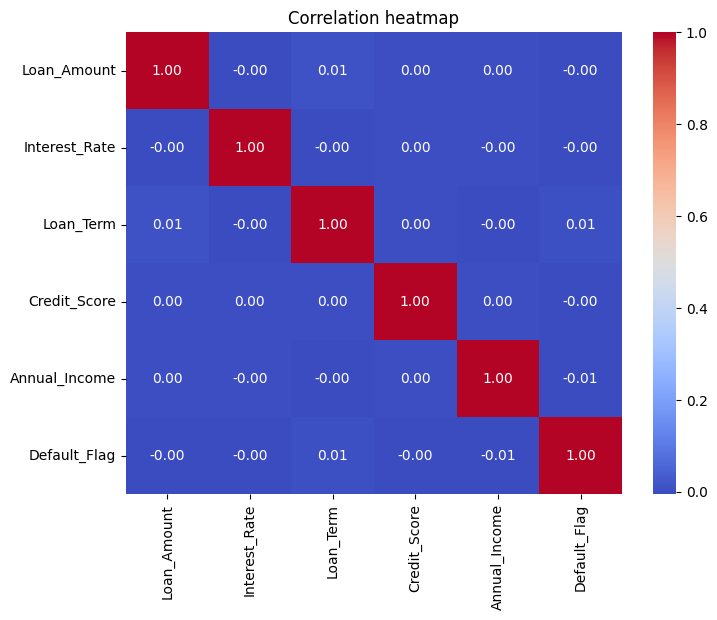

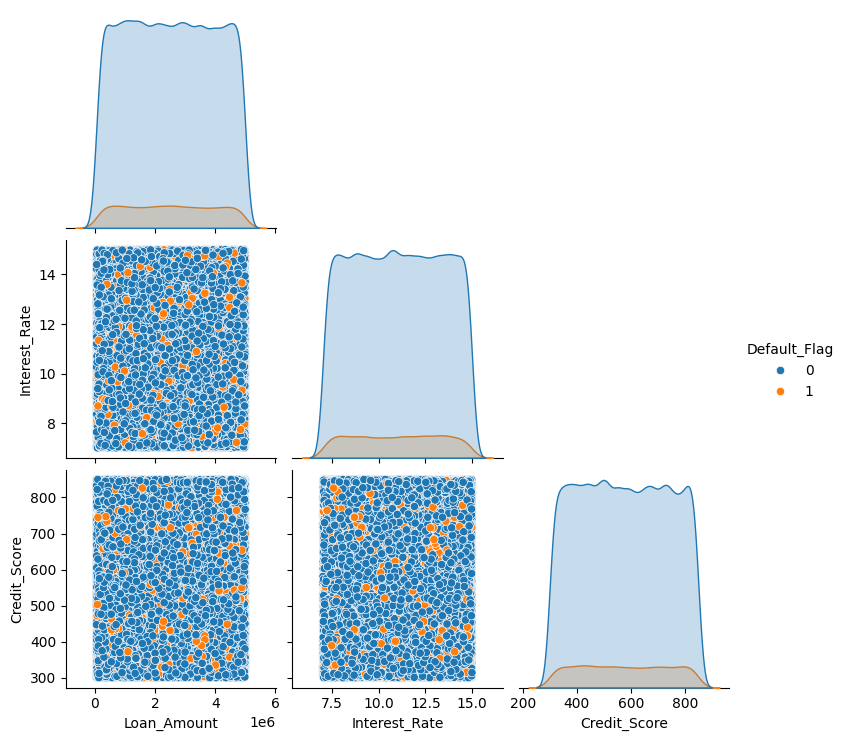

In [86]:
# -------------------------
# Task 3. Default Risk Analysis
# -------------------------

def correlation_analysis(df, cols=None):
    if cols is None:
        cols = ['Loan_Amount','Interest_Rate','Loan_Term','Credit_Score','Annual_Income','Default_Flag']
    sub = df[[c for c in cols if c in df.columns]].select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(sub, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation heatmap')
    plt.show()
    return sub

if loans_enriched is not None:
    corr_mat = correlation_analysis(loans_enriched)

# Pairwise scatter for high-impact variables
if loans_enriched is not None and 'Credit_Score' in loans_enriched.columns:
    sns.pairplot(loans_enriched[['Loan_Amount','Interest_Rate','Credit_Score','Default_Flag']].dropna(), hue='Default_Flag', corner=True)
    plt.show()


In [87]:
# -------------------------
# Task 4. Branch & Regional Performance
# -------------------------

def branch_performance(loans_df):
    if loans_df is None or 'Branch_ID' not in loans_df.columns:
        return None
    df = loans_df.copy()
    summary = df.groupby('Branch_ID').agg(
        total_disbursed=('Loan_Amount','sum'),
        n_loans=('Loan_ID','nunique'),
        defaults=('Default_Flag','sum'),
        avg_interest=('Interest_Rate','mean')
    ).reset_index()
    summary['default_rate'] = summary['defaults'] / summary['n_loans']
    return summary.sort_values('total_disbursed', ascending=False)

branch_summary = branch_performance(loans_enriched)
if branch_summary is not None:
    display(branch_summary.head(10))

# Compare regions
if loans_enriched is not None and 'Region' in loans_enriched.columns:
    region_perf = loans_enriched.groupby('Region').agg(total_disbursed=('Loan_Amount','sum'), n_loans=('Loan_ID','nunique'), defaults=('Default_Flag','sum'))
    region_perf['default_rate'] = region_perf['defaults'] / region_perf['n_loans']
    display(region_perf.sort_values('total_disbursed', ascending=False))


,total_disbursed,n_loans,defaults,default_rate
Region,,,,
East,3.843780e+10,15316,1363,0.088992
North,3.796395e+10,15041,1340,0.089090
South,3.774057e+10,14949,1501,0.100408
West,3.760016e+10,14901,1480,0.099322
Northeast,3.747736e+10,14944,1432,0.095824
Central,3.724344e+10,14849,1423,0.095831


In [88]:
# -------------------------
# Task 5. Customer Segmentation
# -------------------------

def segment_customers(customers_df):
    df = customers_df.copy()
    if 'Credit_Score' in df.columns:
        df['credit_segment'] = pd.cut(df['Credit_Score'], bins=[-1,500,650,750,850], labels=['Very_Low','Low','Medium','High'])
    if 'Annual_Income' in df.columns:
        df['income_quartile'] = pd.qcut(df['Annual_Income'].rank(method='first'), q=4, labels=['Low','Med','High','Very_High'])
    return df

if dfs['customers'] is not None:
    customers_segmented = segment_customers(dfs['customers'])
    display(customers_segmented[['Customer_ID','Credit_Score','credit_segment','Annual_Income','income_quartile']].head())

# Merge customer segments into loans
if loans_enriched is not None and dfs['customers'] is not None and 'Customer_ID' in loans_enriched.columns:
    loans_enriched = loans_enriched.merge(customers_segmented[['Customer_ID','credit_segment','income_quartile']], on='Customer_ID', how='left')

# Segment default rates
if loans_enriched is not None and 'credit_segment' in loans_enriched.columns:
    seg = loans_enriched.groupby('credit_segment').agg(n_loans=('Loan_ID','nunique'), defaults=('Default_Flag','sum'))
    seg['default_rate'] = seg['defaults']/seg['n_loans']
    display(seg.sort_values('default_rate', ascending=False))


,Customer_ID,Credit_Score,credit_segment,Annual_Income,income_quartile
0,C000001,433,Very_Low,886810.0,Med
1,C000002,418,Very_Low,396746.0,Low
2,C000003,736,Medium,1118591.0,High
3,C000004,353,Very_Low,524075.0,Low
4,C000005,735,Medium,1219355.0,High


,n_loans,defaults,default_rate
credit_segment,,,
High,16225,1563,0.096333
Very_Low,33188,3184,0.095938
Medium,16324,1528,0.093605
Low,24263,2264,0.093311


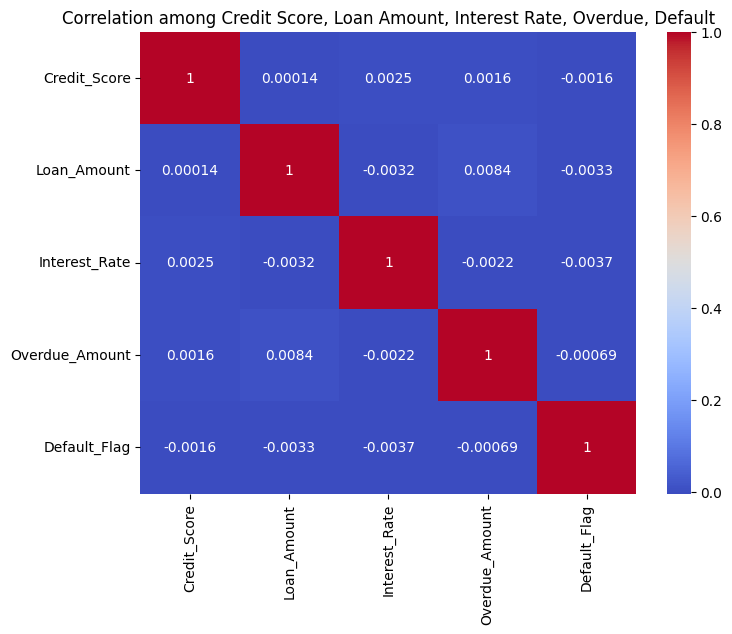

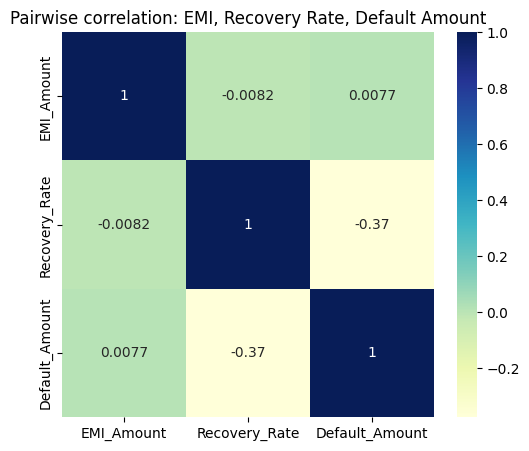

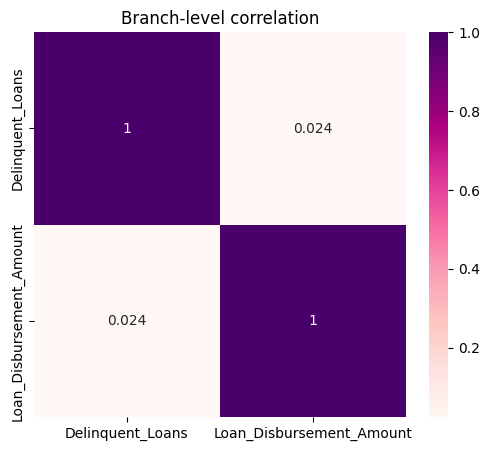

In [89]:
# -------------------------
# Task 6. Advanced Statistical Analysis
# -------------------------

# 1. Correlation Analysis for Default Risks
if loans_enriched is not None:
    cols = [c for c in ['Credit_Score','Loan_Amount','Interest_Rate','Overdue_Amount','Default_Flag'] if c in loans_enriched.columns]
    if len(cols) >= 3:
        corr = loans_enriched[cols].corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation among Credit Score, Loan Amount, Interest Rate, Overdue, Default')
        plt.show()

# 2. Pairwise Correlation Heatmap (EMI, Recovery, Default)
if loans_enriched is not None:
    temp = loans_enriched.copy()
    if dfs['defaults'] is not None and 'Loan_ID' in dfs['defaults'].columns:
        temp = temp.merge(dfs['defaults'][['Loan_ID','Default_Amount','Recovery_Amount']], on='Loan_ID', how='left')
        temp['Recovery_Rate'] = temp.apply(lambda r: (r['Recovery_Amount']/r['Default_Amount']) if pd.notnull(r['Recovery_Amount']) and pd.notnull(r['Default_Amount']) and r['Default_Amount']!=0 else np.nan, axis=1)
        cols = [c for c in ['EMI_Amount','Recovery_Rate','Default_Amount'] if c in temp.columns]
        if len(cols) >= 2:
            corr2 = temp[cols].corr()
            plt.figure(figsize=(6,5))
            sns.heatmap(corr2, annot=True, cmap='YlGnBu')
            plt.title('Pairwise correlation: EMI, Recovery Rate, Default Amount')
            plt.show()

# 3. Branch-Level Correlation
if dfs['branches'] is not None:
    br = dfs['branches'].copy()
    # compute recovery rate from defaults per branch if available
    if dfs['defaults'] is not None and 'Branch_ID' in dfs['defaults'].columns:
        rec = dfs['defaults'].groupby('Branch_ID').apply(lambda d: (d['Recovery_Amount'].sum()/d['Default_Amount'].sum()) if d['Default_Amount'].sum()>0 else np.nan).reset_index().rename(columns={0:'Recovery_Rate'})
        br = br.merge(rec, on='Branch_ID', how='left')
    cols = [c for c in ['Delinquent_Loans','Loan_Disbursement_Amount','Recovery_Rate'] if c in br.columns]
    if len(cols) >= 2:
        corr3 = br[cols].corr()
        plt.figure(figsize=(6,5))
        sns.heatmap(corr3, annot=True, cmap='RdPu')
        plt.title('Branch-level correlation')
        plt.show()

In [154]:
# -------------------------
# Task 7. Transactions & Recovery Analysis
# -------------------------
if dfs['transactions'] is not None:
    # penalty share
    if 'Transaction_Type' in dfs['transactions'].columns and 'Transaction_Amount' in dfs['transactions'].columns:
        t = dfs['transactions'].groupby('Transaction_Type').agg(total_amt=('Transaction_Amount','sum'), n_tx=('Transaction_ID','nunique')).reset_index()
        display(t.sort_values('total_amt', ascending=False))

if dfs['defaults'] is not None:
    dfs['defaults']['recovery_rate'] = dfs['defaults'].apply(lambda r: (r['Recovery_Amount']/r['Default_Amount']) if pd.notnull(r.get('Recovery_Amount')) and pd.notnull(r.get('Default_Amount')) and r['Default_Amount']!=0 else np.nan, axis=1)
    rec_by_branch = None
    if 'Branch_ID' in dfs['defaults'].columns:
        rec_by_branch = dfs['defaults'].groupby('Branch_ID').agg(avg_recovery_rate=('recovery_rate','mean'), n_defaults=('Default_ID','nunique'))
        display(rec_by_branch.sort_values('avg_recovery_rate', ascending=False).head())


In [91]:
# -------------------------
# Task 8. EMI Analysis
# -------------------------
if loans_enriched is not None and 'EMI_Amount' in loans_enriched.columns:
    loans_enriched['emi_bin'] = pd.qcut(loans_enriched['EMI_Amount'], q=5, duplicates='drop')
    emi_default = loans_enriched.groupby('emi_bin').agg(n_loans=('Loan_ID','nunique'), defaults=('Default_Flag','sum'))
    emi_default['default_rate'] = emi_default['defaults']/emi_default['n_loans']
    display(emi_default.sort_values('default_rate', ascending=False))

,n_loans,defaults,default_rate
emi_bin,,,
"(40951.2, 60714.0]",18001,1735,0.096384
"(80297.0, 100000.0]",17998,1729,0.096066
"(60714.0, 80297.0]",18001,1718,0.095439
"(21519.4, 40951.2]",18000,1679,0.093278
"(2000.999, 21519.4]",18000,1678,0.093222


In [92]:
# -------------------------
# Task 9. Loan Application Insights
# -------------------------
if dfs['applications'] is not None:
    apps = dfs['applications']
    if 'Approval_Status' in apps.columns:
        approval_rates = apps['Approval_Status'].value_counts(normalize=True)*100
        print('Approval status distribution (%):')
        display(approval_rates)
    if 'Rejection_Reason' in apps.columns:
        print('\nTop rejection reasons:')
        display(apps['Rejection_Reason'].value_counts().head(10))

Approval status distribution (%):


,proportion
Approval_Status,
Approved,84.745763
Rejected,15.254237



Top rejection reasons:


,count
Rejection_Reason,
Unknown,70000
Low Credit Score,4297
Incomplete Documents,4204
Insufficient Income,4099


In [93]:
# -------------------------
# Task 10: Recovery Effectiveness
# -------------------------
import numpy as np

# Helper to find likely column names
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Defaults dataframe
defaults_df = dfs.get('defaults')
# Use loans_enriched if available, as it contains merged branch info
loans_df_for_merge = loans_enriched.copy() if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')


if defaults_df is None:
    print("No defaults dataframe found in `dfs['defaults']`. Skipping recovery effectiveness.")
else:
    # Standardize column names candidates
    loan_id_col = find_col(defaults_df, ['Loan_ID','loan_id','LoanId'])
    default_amt_col = find_col(defaults_df, ['Default_Amount','DefaultAmount','default_amount','Default Amt'])
    recovery_amt_col = find_col(defaults_df, ['Recovery_Amount','RecoveryAmount','recovery_amount','Recovery Amt'])
    legal_col = find_col(defaults_df, ['Legal_Action','Legal_Action_Flag','LegalAction','legal_action','Legal_Flag'])

    # Ensure numeric
    for c in [default_amt_col, recovery_amt_col]:
        if c is not None:
            defaults_df[c] = pd.to_numeric(defaults_df[c], errors='coerce')

    # Compute recovery rate per default record
    if default_amt_col is None or recovery_amt_col is None:
        print("Missing Default_Amount or Recovery_Amount columns in defaults. Found:", default_amt_col, recovery_amt_col)
    else:
        defaults_df['recovery_rate'] = defaults_df.apply(
            lambda r: (r[recovery_amt_col]/r[default_amt_col]) if pd.notnull(r[recovery_amt_col]) and pd.notnull(r[default_amt_col]) and r[default_amt_col] != 0 else np.nan,
            axis=1
        )
        display(defaults_df[[loan_id_col, default_amt_col, recovery_amt_col, 'recovery_rate']].head())

        # Overall effectiveness
        overall_recovery_rate = defaults_df['recovery_rate'].mean(skipna=True)
        print(f"\nOverall average recovery rate (mean of recovery_rate): {overall_recovery_rate:.3f}")

        # Compare recovery rates: with vs without legal actions
        if legal_col is not None:
            # normalize boolean-like values
            defaults_df['legal_flag'] = defaults_df[legal_col].astype(str).str.lower().isin(['1','true','yes','y','t'])
            grp = defaults_df.groupby('legal_flag').agg(n_defaults=('recovery_rate','count'), mean_recovery=('recovery_rate','mean'))
            print("\nRecovery rates by legal action (True = legal action present):")
            display(grp)
        else:
            print("\nNo Legal_Action-like column found in defaults; cannot split by legal action presence.")

        # Branch-wise recovery performance
        # Try to find Branch_ID in defaults or fall back to loans -> join
        branch_col = find_col(defaults_df, ['Branch_ID','branch_id','BranchId'])
        # Use the loans_enriched DataFrame for merging to get Branch_ID
        if branch_col is None and loan_id_col is not None and loans_df_for_merge is not None and loan_id_col in loans_df_for_merge.columns:
            # merge to get branch from loans_enriched
            merge_on = loan_id_col
            # Ensure 'Branch_ID' is in loans_df_for_merge before trying to select it
            if 'Branch_ID' in loans_df_for_merge.columns:
                merged = defaults_df.merge(loans_df_for_merge[[merge_on,'Branch_ID']].drop_duplicates(), left_on=loan_id_col, right_on=merge_on, how='left')
                branch_col = 'Branch_ID' if 'Branch_ID' in merged.columns else find_col(merged, ['Branch_ID','branch_id'])
                if branch_col is None:
                    print("Could not determine Branch_ID from loans or defaults.")
                else:
                    by_branch = merged.groupby(branch_col).agg(n_defaults=('recovery_rate','count'), avg_recovery_rate=('recovery_rate','mean')).reset_index()
                    by_branch = by_branch.sort_values('avg_recovery_rate', ascending=False)
                    print("\nBranch-wise average recovery rate (top 10):")
                    display(by_branch.head(10))
            else:
                print("loans_enriched DataFrame does not contain 'Branch_ID' column for merging.")

        elif branch_col is not None:
            by_branch = defaults_df.groupby(branch_col).agg(n_defaults=('recovery_rate','count'), avg_recovery_rate=('recovery_rate','mean')).reset_index()
            by_branch = by_branch.sort_values('avg_recovery_rate', ascending=False)
            print("\nBranch-wise average recovery rate (top 10):")
            display(by_branch.head(10))
        else:
            print("No Branch_ID info available in defaults or loans to compute branch-wise recovery.")

,Loan_ID,Default_Amount,Recovery_Amount,recovery_rate
0,L007312,94480.0,30360,0.321338
1,L028234,10912.0,0,0.000000
2,L008319,73711.0,9866,0.133847
3,L046668,48955.0,0,0.000000
4,L082934,56952.0,0,0.000000



Overall average recovery rate (mean of recovery_rate): 0.405

Recovery rates by legal action (True = legal action present):


,n_defaults,mean_recovery
legal_flag,,
False,4550,0.401805
True,4450,0.407372


loans_enriched DataFrame does not contain 'Branch_ID' column for merging.


In [94]:
# -------------------------
# Task 11: Loan Disbursement Efficiency
# -------------------------

def find_col(df, candidates):
    if df is None:
        return None
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Use existing objects
applications_df = dfs.get('applications')
loans_df = loans_enriched.copy() if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')
transactions_df = dfs.get('transactions')

# Candidate names
app_date_candidates = ['Application_Date','application_date','Applied_On','AppliedDate','Date_of_Application','App_Date']
loan_disb_candidates = ['Disbursement_Date','disbursement_date','DisbursementDate','Disbursed_On','Disbursal_Date','DisbursementDt','Date_of_Disbursement','Loan_Start_Date','Start_Date']
loan_approval_candidates = ['Approval_Date','approval_date','Sanction_Date','SanctionDate','Sanctioned_On']
loan_id_candidates = ['Loan_ID','loan_id','LoanId','LoanId']
cust_id_candidates = ['Customer_ID','customer_id','CustomerId','Cust_ID']
loan_purpose_candidates = ['Loan_Purpose','loan_purpose','Purpose','LoanPurpose']
branch_candidates = ['Branch_ID','branch_id','BranchId']
region_candidates = ['Region','region']

# detect columns
app_date_col = find_col(applications_df, app_date_candidates)
loan_disb_col = find_col(loans_df, loan_disb_candidates)
loan_approval_col = find_col(loans_df, loan_approval_candidates)
loan_id_apps_col = find_col(applications_df, loan_id_candidates)
loan_id_loans_col = find_col(loans_df, loan_id_candidates)
cust_col_apps = find_col(applications_df, cust_id_candidates)
cust_col_loans = find_col(loans_df, cust_id_candidates)
loan_purpose_col = find_col(loans_df, loan_purpose_candidates) or find_col(applications_df, loan_purpose_candidates)
branch_col_loans = find_col(loans_df, branch_candidates)
region_col = find_col(loans_df, region_candidates) or find_col(applications_df, region_candidates)

print("Detected columns:")
print(" Application date:", app_date_col)
print(" Loan disbursement date:", loan_disb_col)
print(" Loan approval/sanction date (fallback):", loan_approval_col)
print(" Loan_ID in apps:", loan_id_apps_col, " Loan_ID in loans:", loan_id_loans_col)
print(" Customer_ID apps:", cust_col_apps, " Customer_ID loans:", cust_col_loans)
print(" Loan purpose:", loan_purpose_col, " Branch in loans:", branch_col_loans, " Region:", region_col)

# convert to datetimes where found
if applications_df is not None and app_date_col is not None:
    applications_df[app_date_col] = pd.to_datetime(applications_df[app_date_col], errors='coerce')
if loans_df is not None:
    if loan_disb_col is not None:
        loans_df[loan_disb_col] = pd.to_datetime(loans_df[loan_disb_col], errors='coerce')
    if loan_approval_col is not None:
        loans_df[loan_approval_col] = pd.to_datetime(loans_df[loan_approval_col], errors='coerce')

# infer disbursement from transactions if missing
if loan_disb_col is None and transactions_df is not None:
    tx_type_col = find_col(transactions_df, ['Transaction_Type','transaction_type','Tx_Type','Type'])
    tx_date_col = find_col(transactions_df, ['Transaction_Date','transaction_date','TxDate','Date'])
    tx_loan_col = find_col(transactions_df, ['Loan_ID','loan_id','LoanId'])
    if tx_type_col and tx_date_col and tx_loan_col:
        transactions_df[tx_date_col] = pd.to_datetime(transactions_df[tx_date_col], errors='coerce')
        transactions_df['tx_type_lower'] = transactions_df[tx_type_col].astype(str).str.lower()
        mask = transactions_df['tx_type_lower'].str.contains('disburs|fund|disburse', na=False)
        disb_tx = transactions_df[mask].copy()
        if not disb_tx.empty:
            disb_agg = disb_tx.groupby(tx_loan_col)[tx_date_col].min().reset_index().rename(columns={tx_date_col: 'inferred_disbursement_date'})
            # if loan_id_loans_col exists, merge on that, else left as tx_loan_col
            merge_left = loan_id_loans_col if loan_id_loans_col in loans_df.columns else loan_id_loans_col
            loans_df = loans_df.merge(disb_agg, left_on=loan_id_loans_col, right_on=tx_loan_col, how='left') if loan_id_loans_col in loans_df.columns else loans_df.merge(disb_agg, left_index=True, right_on=tx_loan_col, how='left')
            loan_disb_col = 'inferred_disbursement_date'
            print("Inferred disbursement date from transactions; using:", loan_disb_col)

# fallback to approval date if still missing
if loan_disb_col is None and loan_approval_col is not None:
    loan_disb_col = loan_approval_col
    print("Falling back to approval/sanction date:", loan_disb_col)

# final checks
if applications_df is None:
    raise ValueError("Applications dataframe not found (dfs['applications'] is None).")
if app_date_col is None:
    raise ValueError("No Application_Date-like column found in applications.")
if loans_df is None:
    raise ValueError("Loans dataframe not available.")
if loan_disb_col is None:
    raise ValueError("No disbursement/approval date found and could not infer from transactions. Please provide date column or transaction disbursement records.")

# Build dynamic columns list for merge (only include existing columns)
cols_to_select = []
for c in [loan_id_loans_col, loan_disb_col, loan_purpose_col, branch_col_loans, region_col]:
    if c is not None and c in loans_df.columns:
        cols_to_select.append(c)
# Ensure loan_id_loans_col included if present (useful for joining)
if loan_id_loans_col is not None and loan_id_loans_col in loans_df.columns and loan_id_loans_col not in cols_to_select:
    cols_to_select.insert(0, loan_id_loans_col)

# Preferred merge on Loan_ID
if loan_id_apps_col is not None and loan_id_loans_col is not None and loan_id_loans_col in loans_df.columns:
    right_df = loans_df[cols_to_select].drop_duplicates()
    merged = applications_df.merge(right_df, left_on=loan_id_apps_col, right_on=loan_id_loans_col, how='left', suffixes=('_app','_loan'))
else:
    # fallback: merge on Customer_ID and choose nearest disbursement >= application if multiple matches
    if cust_col_apps is None or cust_col_loans is None or cust_col_loans not in loans_df.columns:
        raise ValueError("Neither Loan_ID join nor valid Customer_ID join possible. Provide Loan_ID or Customer_ID in both datasets.")
    # select relevant loan cols for merge
    cols_to_select_cust = [c for c in [cust_col_loans, loan_id_loans_col, loan_disb_col, loan_purpose_col, branch_col_loans, region_col] if c is not None and c in loans_df.columns]
    merged = applications_df.merge(loans_df[cols_to_select_cust], left_on=cust_col_apps, right_on=cust_col_loans, how='left', suffixes=('_app','_loan'))
    # compute time diff and pick best match per application index
    merged[app_date_col] = pd.to_datetime(merged[app_date_col], errors='coerce')
    merged[loan_disb_col] = pd.to_datetime(merged[loan_disb_col], errors='coerce')
    merged['time_diff_days_temp'] = (merged[loan_disb_col] - merged[app_date_col]).dt.days
    # keep the row with smallest non-negative time_diff if available, else smallest absolute
    merged = merged.sort_values(['time_diff_days_temp']).drop_duplicates(subset=applications_df.index.name or applications_df.index, keep='first')

# Ensure datetimes
merged[app_date_col] = pd.to_datetime(merged[app_date_col], errors='coerce')
merged[loan_disb_col] = pd.to_datetime(merged[loan_disb_col], errors='coerce')

# Compute processing time
merged['processing_time_days'] = (merged[loan_disb_col] - merged[app_date_col]).dt.days

# Summary stats
print("\nProcessing time (days) summary:")
display(merged['processing_time_days'].describe())

# Branch-level bottlenecks
branch_col_final = branch_col_loans if branch_col_loans in merged.columns else find_col(merged, branch_candidates)
if branch_col_final is not None:
    branch_proc = merged.groupby(branch_col_final).agg(
        n_apps=('processing_time_days','count'),
        median_processing=('processing_time_days','median'),
        mean_processing=('processing_time_days','mean')
    ).reset_index().sort_values('median_processing', ascending=False)
    print("\nBranches with highest median processing time (top 10):")
    display(branch_proc.head(10))
else:
    print("\nBranch column not available to compute per-branch processing times.")

# Loan purpose trends
loan_purpose_final = loan_purpose_col if loan_purpose_col in merged.columns else find_col(merged, loan_purpose_candidates)
if loan_purpose_final is not None:
    purpose_proc = merged.groupby(loan_purpose_final).agg(
        n_apps=('processing_time_days','count'),
        median_processing=('processing_time_days','median')
    ).reset_index().sort_values('median_processing', ascending=False)
    print("\nLoan purposes with highest median processing time (top 10):")
    display(purpose_proc.head(10))
else:
    print("\nLoan purpose column not available to analyze disbursement trends by purpose.")

# Regional trends
region_final = region_col if region_col in merged.columns else find_col(merged, region_candidates)
if region_final is not None:
    region_proc = merged.groupby(region_final).agg(
        n_apps=('processing_time_days','count'),
        median_processing=('processing_time_days','median')
    ).reset_index().sort_values('median_processing', ascending=False)
    print("\nRegions by median processing time (top 10):")
    display(region_proc.head(10))
else:
    print("\nRegion column not available to analyze regional disbursement efficiency.")

# Worst individual applications
worst = merged.sort_values('processing_time_days', ascending=False).head(20)
cols_to_show = [c for c in [loan_id_apps_col, cust_col_apps, app_date_col, loan_disb_col, 'processing_time_days', branch_col_final, loan_purpose_final, loan_id_loans_col] if c is not None and c in worst.columns]
print("\nTop 20 applications with longest processing time:")
display(worst[cols_to_show])

# Save summaries if present
OUT_DIR = '/content/hero_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
if 'branch_proc' in locals():
    branch_proc.to_csv(os.path.join(OUT_DIR, 'branch_processing_times.csv'), index=False)
if 'purpose_proc' in locals():
    purpose_proc.to_csv(os.path.join(OUT_DIR, 'purpose_processing_times.csv'), index=False)
if 'region_proc' in locals():
    region_proc.to_csv(os.path.join(OUT_DIR, 'region_processing_times.csv'), index=False)

print(f"\nSaved available summaries to {OUT_DIR}")


Detected columns:
 Application date: Application_Date
 Loan disbursement date: Disbursal_Date
 Loan approval/sanction date (fallback): None
 Loan_ID in apps: Loan_ID  Loan_ID in loans: Loan_ID
 Customer_ID apps: Customer_ID  Customer_ID loans: Customer_ID
 Loan purpose: Loan_Purpose  Branch in loans: None  Region: Region

Processing time (days) summary:


,processing_time_days
count,70000.000000
mean,172.191700
std,824.317006
min,-1822.000000
25%,-424.000000
50%,171.000000
75%,769.000000
max,2184.000000



Branch column not available to compute per-branch processing times.

Loan purposes with highest median processing time (top 10):


,Loan_Purpose,n_apps,median_processing
4,Vehicle,14099,185.0
2,Home Renovation,13994,181.0
3,Personal,13942,167.5
0,Business,13995,164.0
1,Education,13970,164.0



Regions by median processing time (top 10):


,Region,n_apps,median_processing
2,North,11687,187.0
5,West,11645,177.0
3,Northeast,11617,172.0
1,East,11871,170.0
0,Central,11538,166.0
4,South,11642,155.0



Top 20 applications with longest processing time:


,Loan_ID,Customer_ID,Application_Date,Disbursal_Date,processing_time_days,Loan_Purpose,Loan_ID
68458,L068459,C068459,2019-01-04,2024-12-27,2184.0,Vehicle,L068459
11948,L011949,C011949,2019-01-07,2024-12-26,2180.0,Personal,L011949
54952,L054953,C054953,2019-01-18,2024-12-19,2162.0,Business,L054953
23607,L023608,C023608,2019-01-22,2024-12-22,2161.0,Business,L023608
31157,L031158,C031158,2019-01-18,2024-12-18,2161.0,Home Renovation,L031158
66192,L066193,C066193,2019-01-09,2024-12-07,2159.0,Personal,L066193
57342,L057343,C057343,2019-01-15,2024-12-12,2158.0,Vehicle,L057343
55466,L055467,C055467,2019-01-25,2024-12-21,2157.0,Vehicle,L055467
9671,L009672,C009672,2019-01-22,2024-12-16,2155.0,Business,L009672
65921,L065922,C065922,2019-02-01,2024-12-25,2154.0,Business,L065922



Saved available summaries to /content/hero_outputs


In [95]:
# -------------------------
# Task 12. Profitability Analysis (approximate)
# -------------------------
if loans_enriched is not None:
    # approximate interest income = Loan_Amount * Interest_Rate * (Loan_Term/12)
    if all(c in loans_enriched.columns for c in ['Loan_Amount','Interest_Rate','Loan_Term']):
        loans_enriched['estimated_interest_income'] = loans_enriched['Loan_Amount'] * (loans_enriched['Interest_Rate']/100) * (loans_enriched['Loan_Term']/12)
        profit_by_purpose = None
        if 'Loan_Purpose' in loans_enriched.columns:
            profit_by_purpose = loans_enriched.groupby('Loan_Purpose').agg(interest_income=('estimated_interest_income','sum'), n_loans=('Loan_ID','nunique'))
            display(profit_by_purpose.sort_values('interest_income', ascending=False).head())
        print('Total estimated interest income:', loans_enriched['estimated_interest_income'].sum())


Total estimated interest income: 75037526934.92249


In [133]:
# -------------------------
# Task 13: Geospatial Analysis
# -------------------------

# Dataframes (from notebook)
loans = loans_enriched.copy() if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')
branches = dfs.get('branches')
customers = dfs.get('customers')

# Helper to find likely column names
def find_col(df, candidates):
    if df is None:
        return None
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Candidate names
branch_candidates = ['Branch_ID','branch_id','BranchId']
region_candidates = ['Region','region']
area_candidates = ['Urban_Rural','Area_Type','Urbanity','urban_rural','Urban_Rural_Flag','Location_Type']
branch_lat_cands = ['Branch_Latitude','branch_latitude','Lat','latitude']
branch_lon_cands = ['Branch_Longitude','branch_longitude','Lon','longitude']
cust_lat_cands = ['Customer_Latitude','customer_latitude','Lat','latitude']
cust_lon_cands = ['Customer_Longitude','customer_longitude','Lon','longitude']

# detect columns
branch_id_col_in_branches = find_col(branches, branch_candidates)
branch_lat = find_col(branches, branch_lat_cands)
branch_lon = find_col(branches, branch_lon_cands)
region_col = find_col(loans, region_candidates) or find_col(branches, region_candidates) or find_col(customers, region_candidates)
area_col = find_col(customers, area_candidates) or find_col(loans, area_candidates)
cust_lat = find_col(customers, cust_lat_cands)
cust_lon = find_col(customers, cust_lon_cands)
loan_id_loans_col = find_col(loans, ['Loan_ID','loan_id','LoanId'])
cust_id_loans_col = find_col(loans, ['Customer_ID','customer_id','CustomerId'])
cust_id_customers_col = find_col(customers, ['Customer_ID','customer_id','CustomerId'])
default_flag_col = find_col(loans, ['Default_Flag','default_flag']) # assuming this was added in loans_enriched

print("Detected columns for Task 13:")
print(" Branch ID (branches):", branch_id_col_in_branches)
print(" Branch Lat/Lon:", branch_lat, branch_lon)
print(" Region:", region_col)
print(" Area Type:", area_col)
print(" Customer Lat/Lon:", cust_lat, cust_lon)
print(" Default Flag:", default_flag_col)

# 1) If branch-level lat/lon available -> scatter map of active loans (by loan count/sum)
if branches is not None and branch_lat and branch_lon and loans is not None and branch_id_col_in_branches is not None and branch_id_col_in_branches in loans.columns and branch_id_col_in_branches in branches.columns and default_flag_col is not None: # Added check for branch_id_col_in_branches and default_flag_col
    # aggregate loans by branch
    agg = loans.groupby(branch_id_col_in_branches).agg(
        active_loans=('Loan_ID','nunique'),
        total_disbursed=('Loan_Amount','sum'),
        defaults=(default_flag_col,'sum') # Use default_flag_col
    ).reset_index()
    br_geo = branches.merge(agg, on=branch_id_col_in_branches, how='left').fillna({'active_loans':0, 'total_disbursed':0, 'defaults':0})
    br_geo[branch_lat] = pd.to_numeric(br_geo[branch_lat], errors='coerce')
    br_geo[branch_lon] = pd.to_numeric(br_geo[branch_lon], errors='coerce')
    # Save summary
    OUT_DIR = '/content/hero_outputs' # Ensure OUT_DIR is defined
    os.makedirs(OUT_DIR, exist_ok=True)
    br_geo.to_csv(os.path.join(OUT_DIR, 'branch_geospatial_summary.csv'), index=False)
    print("Branch geospatial summary saved:", os.path.join(OUT_DIR, 'branch_geospatial_summary.csv'))
    # Plot interactive map (mapbox is optional; this will use open-street-map)
    fig = px.scatter_mapbox(
        br_geo.dropna(subset=[branch_lat, branch_lon]),
        lat=branch_lat, lon=branch_lon,
        size='total_disbursed',
        color='defaults',
        hover_name=branch_id_col_in_branches,
        hover_data={'total_disbursed':True, 'active_loans':True, branch_lat:False, branch_lon:False},
        zoom=3,
        title='Branch locations sized by total disbursed, colored by defaults'
    )
    fig.update_layout(mapbox_style='open-street-map', height=700)
    fig.show()
else:
    print("Branch lat/lon or branch join not possible or Default_Flag missing. Falling back to region-level maps/plots.")

# 2) Region-level summary & choropleth-like bar plots (fallback)
if region_col and loans is not None and default_flag_col is not None: # Added check for default_flag_col
    region_summary = loans.groupby(region_col).agg(
        n_loans=('Loan_ID','nunique'),
        total_disbursed=('Loan_Amount','sum'),
        defaults=(default_flag_col,'sum') # Use default_flag_col
    ).reset_index()
    region_summary['default_rate'] = (region_summary['defaults'] / region_summary['n_loans']).fillna(0)
    OUT_DIR = '/content/hero_outputs' # Ensure OUT_DIR is defined
    os.makedirs(OUT_DIR, exist_ok=True)
    region_summary.to_csv(os.path.join(OUT_DIR, 'region_geospatial_summary.csv'), index=False)
    print("Region-level summary saved:", os.path.join(OUT_DIR, 'region_geospatial_summary.csv'))

    # Bar: total disbursed by region
    fig = px.bar(region_summary.sort_values('total_disbursed', ascending=False), x=region_col, y='total_disbursed', title='Total Loan Disbursement by Region')
    fig.show()

    # Bar: default rate by region
    fig = px.bar(region_summary.sort_values('default_rate', ascending=False), x=region_col, y='default_rate', title='Default Rate by Region')
    fig.update_yaxes(tickformat='.0%')
    fig.show()
else:
    print("No Region column or Default_Flag found in loans/branches/customers for region-level summaries.")

# 3) Urban vs Rural analysis (if applicable)
if area_col and loans is not None and default_flag_col is not None: # Added check for default_flag_col
    # merge area info to loans (try customer then branch)
    loans_area = loans.copy()
    merged_area = False
    if cust_id_loans_col is not None and customers is not None and cust_id_customers_col is not None and area_col in customers.columns:
        loans_area = loans_area.merge(customers[[cust_id_customers_col, area_col]], left_on=cust_id_loans_col, right_on=cust_id_customers_col, how='left')
        merged_area = True
    elif branch_id_col_in_branches is not None and branch_id_col_in_branches in loans_area.columns and branches is not None and area_col in branches.columns:
        loans_area = loans_area.merge(branches[[branch_id_col_in_branches, area_col]], on=branch_id_col_in_branches, how='left')
        merged_area = True

    if merged_area and area_col in loans_area.columns:
        loans_area[area_col] = loans_area[area_col].fillna('Unknown')
        area_summary = loans_area.groupby(area_col).agg(
            n_loans=('Loan_ID','nunique'),
            total_disbursed=('Loan_Amount','sum'),
            defaults=(default_flag_col,'sum') # Use default_flag_col
        ).reset_index()
        area_summary['default_rate'] = (area_summary['defaults']/area_summary['n_loans']).fillna(0)
        OUT_DIR = '/content/hero_outputs' # Ensure OUT_DIR is defined
        os.makedirs(OUT_DIR, exist_ok=True)
        area_summary.to_csv(os.path.join(OUT_DIR, 'urban_rural_summary.csv'), index=False)
        print("Urban/Rural summary saved:", os.path.join(OUT_DIR, 'urban_rural_summary.csv'))
        display(area_summary)

        # Plot
        fig = px.bar(area_summary, x=area_col, y='total_disbursed', title='Disbursement by Area Type')
        fig.show()
        fig = px.bar(area_summary, x=area_col, y='default_rate', title='Default Rate by Area Type')
        fig.update_yaxes(tickformat='.0%')
        fig.show()
    else:
         print("Area type column not available after merging; skipped rural vs urban analysis.")
else:
    print("No Urban/Rural (area type) column or Default_Flag found; skipped rural vs urban analysis.")


# 4) If customer lat/lon available -> customer-level loan density map
if customers is not None and cust_lat and cust_lon and cust_id_customers_col is not None and loans is not None and cust_id_loans_col is not None and default_flag_col is not None: # Added check for default_flag_col
    # merge first loan amounts to customer locations
    cust_loc = customers[[ cust_id_customers_col, cust_lat, cust_lon ]].dropna().rename(columns={cust_id_customers_col:'Customer_ID'}) # Rename to Customer_ID for merging
    cust_loc[cust_lat] = pd.to_numeric(cust_loc[cust_lat], errors='coerce')
    cust_loc[cust_lon] = pd.to_numeric(cust_loc[cust_lon], errors='coerce')
    loan_by_cust = loans.groupby(cust_id_loans_col).agg(total_disbursed=('Loan_Amount','sum'), n_loans=('Loan_ID','nunique'), defaults=(default_flag_col,'sum')).reset_index().rename(columns={cust_id_loans_col:'Customer_ID'}) # Use default_flag_col and rename to Customer_ID
    cust_agg = cust_loc.merge(loan_by_cust, on='Customer_ID', how='left').fillna(0)
    OUT_DIR = '/content/hero_outputs' # Ensure OUT_DIR is defined
    os.makedirs(OUT_DIR, exist_ok=True)
    cust_agg.to_csv(os.path.join(OUT_DIR, 'customer_geospatial_summary.csv'), index=False)
    fig = px.scatter_mapbox(cust_agg.dropna(subset=[cust_lat,cust_lon]), lat=cust_lat, lon=cust_lon,
                            size='total_disbursed', color='defaults', hover_name='Customer_ID',
                            title='Customer loan distribution (size by disbursed amount)',
                            zoom=3)
    fig.update_layout(mapbox_style='open-street-map', height=700)
    fig.show()
else:
    print("No customer lat/lon available or Customer_ID link missing or Default_Flag missing; skipped customer-level map.")


Detected columns for Task 13:
 Branch ID (branches): Branch_ID
 Branch Lat/Lon: None None
 Region: Region
 Area Type: None
 Customer Lat/Lon: None None
 Default Flag: Default_Flag
Branch lat/lon or branch join not possible or Default_Flag missing. Falling back to region-level maps/plots.
Region-level summary saved: /content/hero_outputs/region_geospatial_summary.csv


No Urban/Rural (area type) column or Default_Flag found; skipped rural vs urban analysis.
No customer lat/lon available or Customer_ID link missing or Default_Flag missing; skipped customer-level map.

Geospatial analysis completed. Summaries saved to /content/hero_outputs


In [134]:
# -------------------------
# Task 14 : Default Trends
# -------------------------

OUT_DIR = '/content/hero_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

# Helper to find candidate column
def find_col(df, candidates):
    if df is None:
        return None
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Dataframes (from notebook)
defaults_df = dfs.get('defaults')
loans = loans_enriched.copy() if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')
customers = dfs.get('customers')

# Column candidates
default_date_cands = ['Default_Date','default_date','DefaultDate','Date_of_Default','default_on']
default_amt_cands = ['Default_Amount','DefaultAmount','default_amount','Amount_Default']
loan_id_candidates = ['Loan_ID','loan_id','LoanId']
loan_purpose_cands = ['Loan_Purpose','loan_purpose','Purpose','LoanPurpose']
cust_id_candidates = ['Customer_ID','customer_id','CustomerId','Cust_ID']
annual_income_cands = ['Annual_Income','annual_income','Income','AnnualIncome','Income_Amount']

# detect columns
default_date_col = find_col(defaults_df, default_date_cands)
default_amt_col = find_col(defaults_df, default_amt_cands)
default_loanid_col = find_col(defaults_df, loan_id_candidates)
loan_id_loans_col = find_col(loans, loan_id_candidates)
loan_purpose_col = find_col(loans, loan_purpose_cands)
cust_id_loans_col = find_col(loans, cust_id_candidates)
cust_id_defaults_col = find_col(defaults_df, cust_id_candidates)
cust_id_customers_col = find_col(customers, cust_id_candidates)
annual_income_col = find_col(customers, annual_income_cands)

print("Detected columns (defaults / loans / customers):")
print(" Default date:", default_date_col)
print(" Default amount:", default_amt_col)
print(" Default loan id:", default_loanid_col)
print(" Loan_ID in loans:", loan_id_loans_col)
print(" Loan purpose:", loan_purpose_col)
print(" Customer_ID loans:", cust_id_loans_col, " Customer_ID defaults:", cust_id_defaults_col, " Customer_ID customers:", cust_id_customers_col)
print(" Annual income:", annual_income_col)

# Basic checks
if defaults_df is None:
    raise ValueError("No defaults dataframe (dfs['defaults']) — cannot run default trends.")
if default_date_col is None:
    # try to infer default date from loans or transactions? but require default date for trend -> raise informative error
    raise ValueError("No Default_Date-like column found in defaults. Please provide default date column in defaults dataset.")

# ensure types
defaults_df[default_date_col] = pd.to_datetime(defaults_df[default_date_col], errors='coerce')
if default_amt_col is not None:
    defaults_df[default_amt_col] = pd.to_numeric(defaults_df[default_amt_col], errors='coerce')

# 1) Number of defaults over time (monthly & yearly)
defaults_df['def_month'] = defaults_df[default_date_col].dt.to_period('M').dt.to_timestamp()
defaults_df['def_year'] = defaults_df[default_date_col].dt.year

# Use a valid ID column for counting, fallback to index
id_col_for_count = 'Default_ID' if 'Default_ID' in defaults_df.columns else (default_loanid_col if default_loanid_col is not None else None)
if id_col_for_count is None:
    # fallback to index count if no other ID is found
    defaults_df['__tmp_default_index'] = defaults_df.index
    id_col_for_count = '__tmp_default_index'


monthly_defaults = defaults_df.groupby('def_month').agg(n_defaults=(id_col_for_count, 'nunique')).reset_index()
monthly_defaults = monthly_defaults.sort_values('def_month')
print("\nMonthly defaults summary (head):")
display(monthly_defaults.head())

# Plot monthly defaults
fig = px.line(monthly_defaults, x='def_month', y='n_defaults', title='Monthly number of defaults', markers=True)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Number of defaults')
fig.show()

# Yearly defaults
yearly_defaults = defaults_df.groupby('def_year').agg(n_defaults=(id_col_for_count, 'nunique')).reset_index().sort_values('def_year')
print("\nYearly defaults summary:")
display(yearly_defaults)
fig = px.bar(yearly_defaults, x='def_year', y='n_defaults', title='Yearly defaults')
fig.show()

# 2) Average default amount by loan purpose
# Need to join defaults -> loans to get Loan_Purpose
join_left = default_loanid_col if default_loanid_col in defaults_df.columns else None
join_right = loan_id_loans_col if loan_id_loans_col in loans.columns else None

defaults_loans = defaults_df.copy()
if join_left and join_right and loan_purpose_col is not None: # Added check for loan_purpose_col
    # merge on loan id
    defaults_loans = defaults_loans.merge(loans[[join_right, loan_purpose_col]].drop_duplicates(), left_on=join_left, right_on=join_right, how='left')
elif cust_id_defaults_col and cust_id_loans_col and cust_id_loans_col in loans.columns and loan_purpose_col is not None: # Added check for loan_purpose_col
    # fallback: try to get customer_id present in defaults and join to loans by customer (coarser)
    defaults_loans = defaults_loans.merge(loans[[cust_id_loans_col, loan_purpose_col]].drop_duplicates(), left_on=cust_id_defaults_col, right_on=cust_id_loans_col, how='left')
else:
    print("Could not attach Loan_Purpose to defaults (missing Loan_ID or Customer_ID linkage, or Loan_Purpose column). Skipping avg default by purpose.")
    loan_purpose_col = None # Ensure loan_purpose_col is None if merge failed

if loan_purpose_col and loan_purpose_col in defaults_loans.columns and default_amt_col is not None:
    purpose_defaults = defaults_loans.groupby(loan_purpose_col).agg(
        n_defaults=(default_amt_col, 'count'),
        avg_default_amt=(default_amt_col, 'mean'),
        total_default_amt=(default_amt_col, 'sum')
    ).reset_index().sort_values('avg_default_amt', ascending=False)
    print("\nAverage default amount by loan purpose (top 10):")
    display(purpose_defaults.head(10))
    fig = px.bar(purpose_defaults.sort_values('avg_default_amt', ascending=False).head(10), x=loan_purpose_col, y='avg_default_amt', title='Top loan purposes by average default amount')
    fig.show()
else:
    print("\nLoan purpose or default amount column missing — could not compute average default by purpose.")

# 3) Compare default rates across customer income categories
# For default rate we need total loans per customer and defaults per customer -> compute rate by income quartile
# Determine customer ID to use: prefer Customer_ID in loans or defaults
cust_id_for_merge = cust_id_customers_col or cust_id_loans_col or cust_id_defaults_col

# Build loans_per_customer and defaults_per_customer
if cust_id_for_merge is None:
    print("\nNo Customer_ID found in datasets — skipping default rates by income.")
else:
    # ensure customers has income
    if customers is None or annual_income_col is None:
        print("\nCustomers or Annual_Income column missing — cannot compute default rates across income categories.")
    else:
        # loans per customer
        if cust_id_loans_col in loans.columns:
            loans_per_cust = loans.groupby(cust_id_loans_col).agg(n_loans=('Loan_ID','nunique')).reset_index().rename(columns={cust_id_loans_col:'Customer_ID'})
        else:
            loans_per_cust = pd.DataFrame(columns=['Customer_ID','n_loans'])
        # defaults per customer: try defaults -> customer_id
        if cust_id_defaults_col in defaults_df.columns:
            defaults_per_cust = defaults_df.groupby(cust_id_defaults_col).agg(n_defaults=(default_amt_col if default_amt_col is not None else (default_loanid_col if default_loanid_col is not None else 'Default_ID'),'count')).reset_index().rename(columns={cust_id_defaults_col:'Customer_ID'})
        else:
            # try to derive customer via loans: join defaults->loans to get customer id
            if join_left and join_right:
                tmp = defaults_df.merge(loans[[join_right, cust_id_loans_col]].drop_duplicates(), left_on=join_left, right_on=join_right, how='left')
                if cust_id_loans_col in tmp.columns:
                    defaults_per_cust = tmp.groupby(cust_id_loans_col).agg(n_defaults=(join_left,'count')).reset_index().rename(columns={cust_id_loans_col:'Customer_ID'})
                else:
                    defaults_per_cust = pd.DataFrame(columns=['Customer_ID','n_defaults'])
            else:
                defaults_per_cust = pd.DataFrame(columns=['Customer_ID','n_defaults'])

        # merge loans/defaults to customer and attach income
        cust_stats = customers[[cust_id_customers_col, annual_income_col]].drop_duplicates().rename(columns={cust_id_customers_col:'Customer_ID', annual_income_col:'Annual_Income'}) if customers is not None and cust_id_customers_col in customers.columns else pd.DataFrame(columns=['Customer_ID','Annual_Income'])
        if not loans_per_cust.empty:
            cust_stats = cust_stats.merge(loans_per_cust.rename(columns={'Customer_ID':'Customer_ID'}), on='Customer_ID', how='left')
        if not defaults_per_cust.empty:
            cust_stats = cust_stats.merge(defaults_per_cust.rename(columns={'Customer_ID':'Customer_ID'}), on='Customer_ID', how='left')

        # fillna zeros
        cust_stats['n_loans'] = cust_stats.get('n_loans', pd.Series(dtype=int)).fillna(0)
        cust_stats['n_defaults'] = cust_stats.get('n_defaults', pd.Series(dtype=int)).fillna(0)
        cust_stats['Annual_Income'] = pd.to_numeric(cust_stats['Annual_Income'], errors='coerce')

        # compute default_rate per customer (defaults / loans) with safe handling
        cust_stats['default_rate_customer'] = cust_stats.apply(lambda r: (r['n_defaults']/r['n_loans']) if r['n_loans']>0 else np.nan, axis=1)

        # create income quartiles
        cust_stats = cust_stats.dropna(subset=['Annual_Income'])
        if cust_stats.empty:
            print("\nNo customers with Annual_Income available to compute income-segment default rates.")
        else:
            cust_stats['income_quartile'] = pd.qcut(cust_stats['Annual_Income'], q=4, labels=['Low','Med','High','Very_High'])
            income_default = cust_stats.groupby('income_quartile').agg(
                customers_count=('Customer_ID','nunique'),
                avg_default_rate=('default_rate_customer','mean'),
                total_loans=('n_loans','sum'),
                total_defaults=('n_defaults','sum')
            ).reset_index().sort_values('avg_default_rate', ascending=False)
            print("\nDefault rates by income quartile:")
            display(income_default)
            fig = px.bar(income_default, x='income_quartile', y='avg_default_rate', title='Average default rate by income quartile')
            fig.update_yaxes(tickformat='.0%')
            fig.show()

# Save outputs
if 'monthly_defaults' in locals() and isinstance(monthly_defaults, pd.DataFrame):
    monthly_defaults.to_csv(os.path.join(OUT_DIR, 'monthly_defaults.csv'), index=False)
if 'yearly_defaults' in locals() and isinstance(yearly_defaults, pd.DataFrame):
    yearly_defaults.to_csv(os.path.join(OUT_DIR, 'yearly_defaults.csv'), index=False)
if 'purpose_defaults' in locals() and isinstance(purpose_defaults, pd.DataFrame):
    purpose_defaults.to_csv(os.path.join(OUT_DIR, 'avg_default_by_purpose.csv'), index=False)
if 'income_default' in locals() and isinstance(income_default, pd.DataFrame):
    income_default.to_csv(os.path.join(OUT_DIR, 'default_rate_by_income_quartile.csv'), index=False)

print("\nSaved default trend summaries to", OUT_DIR)

Detected columns (defaults / loans / customers):
 Default date: Default_Date
 Default amount: Default_Amount
 Default loan id: Loan_ID
 Loan_ID in loans: Loan_ID
 Loan purpose: None
 Customer_ID loans: Customer_ID  Customer_ID defaults: Customer_ID  Customer_ID customers: Customer_ID
 Annual income: Annual_Income

Monthly defaults summary (head):


,def_month,n_defaults
0,2021-01-01,164
1,2021-02-01,171
2,2021-03-01,189
3,2021-04-01,196
4,2021-05-01,195



Yearly defaults summary:


,def_year,n_defaults
0,2021,2195
1,2022,2288
2,2023,2178
3,2024,2332
4,2025,7


Could not attach Loan_Purpose to defaults (missing Loan_ID or Customer_ID linkage, or Loan_Purpose column). Skipping avg default by purpose.

Loan purpose or default amount column missing — could not compute average default by purpose.

Default rates by income quartile:


,income_quartile,customers_count,avg_default_rate,total_loans,total_defaults
3,Very_High,17500,0.072798,22475.0,1795.0
1,Med,17500,0.072586,22508.0,1760.0
2,High,17500,0.069986,22517.0,1742.0
0,Low,17500,0.068563,22500.0,1717.0



Saved default trend summaries to /content/hero_outputs


In [117]:
# -------------------------
# Task 15 : Branch Efficiency
# -------------------------

# Use existing objects (from previous setup)
apps = applications  # dfs['applications']
lns  = loans if 'loans' in globals() else (loans_enriched if 'loans_enriched' in globals() else dfs.get('loans'))
cust = customers
brs  = branches

# Convert relevant dates
apps['Application_Date'] = pd.to_datetime(apps.get('Application_Date'), errors='coerce')
# prefer explicit disbursement date, otherwise fallback to approval date
if lns is not None:
    if 'Disbursement_Date' in lns.columns:
        lns['Disbursement_Date'] = pd.to_datetime(lns['Disbursement_Date'], errors='coerce')
    elif 'Approval_Date' in lns.columns:
        lns['Disbursement_Date'] = pd.to_datetime(lns['Approval_Date'], errors='coerce')

# Merge apps -> loans to bring Disbursement_Date (if Loan_ID exists)
if ('Loan_ID' in apps.columns) and (lns is not None and 'Loan_ID' in lns.columns):
    apps_loans = apps.merge(lns[['Loan_ID','Disbursement_Date']], on='Loan_ID', how='left')
else:
    apps_loans = apps.copy()

# Compute processing_days where possible
if 'Disbursement_Date' in apps_loans.columns:
    apps_loans['processing_days'] = (pd.to_datetime(apps_loans['Disbursement_Date'], errors='coerce') - pd.to_datetime(apps_loans['Application_Date'], errors='coerce')).dt.days
else:
    apps_loans['processing_days'] = np.nan

# Ensure Branch_ID is attached to apps_loans:
# 1) If already in applications -> use it
if 'Branch_ID' in apps_loans.columns:
    pass
else:
    # 2) Try to attach Branch_ID from loans (if loans has Branch_ID and Loan_ID exists)
    if lns is not None and 'Branch_ID' in lns.columns and 'Loan_ID' in apps_loans.columns:
        apps_loans = apps_loans.merge(lns[['Loan_ID','Branch_ID']].drop_duplicates(), on='Loan_ID', how='left')
    # 3) Else try attaching Branch_ID from customers (if customers has Branch_ID and Customer_ID exists)
    elif cust is not None and 'Branch_ID' in cust.columns and 'Customer_ID' in apps_loans.columns:
        apps_loans = apps_loans.merge(cust[['Customer_ID','Branch_ID']].drop_duplicates(), on='Customer_ID', how='left')
    # If still not present, apps_loans may not be linkable to branches — we'll fallback later.

# Now compute branch-level efficiency if Branch_ID present
if 'Branch_ID' in apps_loans.columns and apps_loans['Branch_ID'].notna().any():
    branch_eff = apps_loans.groupby('Branch_ID').agg(
        n_applications=('processing_days','count'),
        avg_processing_days=('processing_days','mean'),
        median_processing_days=('processing_days','median')
    ).reset_index().sort_values('avg_processing_days')
    print("Average loan disbursement time per branch (top 20):")
    display(branch_eff.head(20))
    branch_eff.to_csv('/content/hero_outputs/branch_efficiency.csv', index=False)
else:
    print("Branch_ID still not found in merged apps_loans — cannot produce branch-level efficiency. See sample of apps_loans for inspection:")
    display(apps_loans.head(10))
    # still save a processing sample for manual inspection
    apps_loans[['Loan_ID','Customer_ID','Application_Date','Disbursement_Date','processing_days']].head(50).to_csv('/content/hero_outputs/apps_loans_processing_sample.csv', index=False)
    print("Saved apps_loans_processing_sample.csv to /content/hero_outputs")

# Identify branches with most rejected applications (if Approval_Status present)
if 'Approval_Status' in apps.columns:
    rej_mask = apps['Approval_Status'].astype(str).str.lower().isin(['rejected','reject','denied'])
    rejections = apps[rej_mask].copy()
    # ensure Branch_ID present in apps (if not, try to use apps_loans' Branch_ID)
    if 'Branch_ID' in rejections.columns:
        by_branch_rej = rejections.groupby('Branch_ID').size().reset_index(name='n_rejections').sort_values('n_rejections', ascending=False)
    elif 'Branch_ID' in apps_loans.columns:
        # map rejections to branch via Loan_ID or Customer_ID
        # prefer Loan_ID mapping
        if 'Loan_ID' in apps.columns and 'Loan_ID' in apps_loans.columns:
            rej_with_branch = rejections.merge(apps_loans[['Loan_ID','Branch_ID']].drop_duplicates(), on='Loan_ID', how='left')
            by_branch_rej = rej_with_branch.groupby('Branch_ID').size().reset_index(name='n_rejections').sort_values('n_rejections', ascending=False)
        elif 'Customer_ID' in apps.columns and 'Customer_ID' in apps_loans.columns:
            rej_with_branch = rejections.merge(apps_loans[['Customer_ID','Branch_ID']].drop_duplicates(), on='Customer_ID', how='left')
            by_branch_rej = rej_with_branch.groupby('Branch_ID').size().reset_index(name='n_rejections').sort_values('n_rejections', ascending=False)
        else:
            by_branch_rej = pd.DataFrame(columns=['Branch_ID','n_rejections'])
    else:
        by_branch_rej = pd.DataFrame(columns=['Branch_ID','n_rejections'])
    if not by_branch_rej.empty:
        print("\nBranches with the highest number of rejected applications (top 20):")
        display(by_branch_rej.head(20))
        by_branch_rej.to_csv('/content/hero_outputs/branch_rejections.csv', index=False)
    else:
        print("\nCould not aggregate rejected applications by branch (Branch_ID mapping missing).")
else:
    print("\nNo Approval_Status column in applications; skipped rejection counts.")

# Compare branch efficiency vs customer satisfaction if branches table has Customer_Satisfaction
if 'Branch_ID' in apps_loans.columns and brs is not None and 'Customer_Satisfaction' in brs.columns:
    # Standardize branch id naming before merge
    branch_id_col_in_branches = 'Branch_ID' if 'Branch_ID' in brs.columns else next((c for c in brs.columns if c.lower()=='branch_id'), None)
    if 'branch_eff' not in locals() and 'branch_eff' not in globals():
        # create branch_eff if not created (maybe earlier branch_eff was made)
        if 'Branch_ID' in apps_loans.columns:
            branch_eff = apps_loans.groupby('Branch_ID').agg(
                n_applications=('processing_days','count'),
                avg_processing_days=('processing_days','mean'),
                median_processing_days=('processing_days','median')
            ).reset_index()
    if 'branch_eff' in locals() or 'branch_eff' in globals():
        be = branch_eff.merge(brs[[branch_id_col_in_branches,'Customer_Satisfaction']].drop_duplicates(), left_on='Branch_ID', right_on=branch_id_col_in_branches, how='left')
        print("\nBranch efficiency vs Customer Satisfaction (sample):")
        display(be.head(20))
        be.to_csv('/content/hero_outputs/branch_eff_vs_satisfaction.csv', index=False)
    else:
        print("\nBranch efficiency not available to compare with satisfaction.")
else:
    print("\nNo Customer_Satisfaction column in branches or no Branch_ID mapping available; skipping satisfaction comparison.")


Branch_ID still not found in merged apps_loans — cannot produce branch-level efficiency. See sample of apps_loans for inspection:


,Application_ID,Loan_ID,Customer_ID,Application_Date,Approval_Date,Loan_Purpose,Source_Channel,Processing_Fee,Approval_Status,Rejection_Reason,Loan_ID_missing_flag,Approval_Date_missing_flag,Rejection_Reason_missing_flag,Disbursement_Date,processing_days
0,A000001,L000001,C000001,2022-05-11,2020-10-02,Business,Agent,6427,Approved,Unknown,0,1970-01-01,1,NaT,NaN
1,A000002,L000002,C000002,2022-03-18,2022-11-29,Education,Online,8605,Approved,Unknown,0,1970-01-01,1,NaT,NaN
2,A000003,L000003,C000003,2022-01-17,2023-07-01,Business,Online,1450,Approved,Unknown,0,1970-01-01,1,NaT,NaN
3,A000004,L000004,C000004,2019-03-09,2024-08-30,Home Renovation,Agent,8171,Approved,Unknown,0,1970-01-01,1,NaT,NaN
4,A000005,L000005,C000005,2024-07-18,2020-03-18,Education,Branch,4931,Approved,Unknown,0,1970-01-01,1,NaT,NaN
5,A000006,L000006,C000006,2021-06-03,2024-06-06,Vehicle,Online,3847,Approved,Unknown,0,1970-01-01,1,NaT,NaN
6,A000007,L000007,C000007,2021-04-04,2024-10-04,Vehicle,Agent,6322,Approved,Unknown,0,1970-01-01,1,NaT,NaN
7,A000008,L000008,C000008,2020-01-23,2021-08-13,Personal,Agent,2079,Approved,Unknown,0,1970-01-01,1,NaT,NaN
8,A000009,L000009,C000009,2022-04-07,2021-02-20,Home Renovation,Online,7898,Approved,Unknown,0,1970-01-01,1,NaT,NaN
9,A000010,L000010,C000010,2021-03-12,2022-08-03,Personal,Online,1017,Approved,Unknown,0,1970-01-01,1,NaT,NaN


Saved apps_loans_processing_sample.csv to /content/hero_outputs

Could not aggregate rejected applications by branch (Branch_ID mapping missing).

No Customer_Satisfaction column in branches or no Branch_ID mapping available; skipping satisfaction comparison.


In [128]:
# Task 16: Time-Series Analysis

# Use loans_enriched if present, else loans
loans_df = loans_enriched if 'loans_enriched' in globals() and loans_enriched is not None else loans

# Column names used (edit here if your file uses different names)
DISB_COL = 'Disbursement_Date'   # fallback: 'Approval_Date' if not available
AMT_COL  = 'Loan_Amount'
LOAN_ID  = 'Loan_ID'

# prefer explicit Disbursement_Date, else Approval_Date
if DISB_COL not in loans_df.columns and 'Approval_Date' in loans_df.columns:
    loans_df[DISB_COL] = loans_df['Approval_Date']
loans_df[DISB_COL] = pd.to_datetime(loans_df[DISB_COL], errors='coerce')

# drop rows without date for time-series
loans_ts = loans_df.dropna(subset=[DISB_COL]).copy()
loans_ts['disb_month'] = loans_ts[DISB_COL].dt.to_period('M').dt.to_timestamp()

# monthly totals (last 5 years)
cutoff = pd.Timestamp.now() - pd.DateOffset(years=5)
monthly = (loans_ts[loans_ts['disb_month'] >= cutoff]
           .groupby('disb_month')
           .agg(total_disbursed=(AMT_COL,'sum'),
                n_loans=(LOAN_ID,'nunique'))
           .reset_index()
           .sort_values('disb_month'))

monthly['rolling_3m'] = monthly['total_disbursed'].rolling(3, min_periods=1).mean()
monthly['mom_pct'] = monthly['total_disbursed'].pct_change().fillna(0)

# plots
print("Monthly disbursement sample:")
display(monthly.head())
fig = px.line(monthly, x='disb_month', y=['total_disbursed','rolling_3m'],
              labels={'value':'Amount','disb_month':'Month'},
              title='Monthly Loan Disbursement & 3-month Rolling Avg')
fig.show()

# defaults time-series and default rate (if defaults dataset exists)
if 'defaults' in globals() and defaults is not None and any(c in defaults.columns for c in ['Default_Date','default_date','DefaultDate']):
    DCOL = next(c for c in ['Default_Date','default_date','DefaultDate'] if c in defaults.columns)
    defaults[DCOL] = pd.to_datetime(defaults[DCOL], errors='coerce')
    defaults_ts = defaults.dropna(subset=[DCOL]).copy()
    defaults_ts['def_month'] = defaults_ts[DCOL].dt.to_period('M').dt.to_timestamp()
    monthly_defaults = defaults_ts.groupby('def_month').agg(n_defaults=(LOAN_ID,'nunique')).reset_index()
    merged = monthly.merge(monthly_defaults, left_on='disb_month', right_on='def_month', how='left').fillna(0)
    merged['default_rate'] = merged['n_defaults'] / merged['n_loans'].replace(0, pd.NA)
    fig = px.line(merged, x='disb_month', y='default_rate', title='Monthly Default Rate'); fig.update_yaxes(tickformat='.0%'); fig.show()
    merged.to_csv('/content/hero_outputs/monthly_defaults_vs_loans.csv', index=False)

# seasonality
monthly['month'] = monthly['disb_month'].dt.month
season = monthly.groupby('month').agg(avg_disb=('total_disbursed','mean')).reset_index()
display(season)
season.to_csv('/content/hero_outputs/seasonality_by_month.csv', index=False)
monthly.to_csv('/content/hero_outputs/monthly_disbursement.csv', index=False)

print("Task 16 done — CSVs saved to /content/hero_outputs")


Monthly disbursement sample:


,disb_month,total_disbursed,n_loans,rolling_3m,mom_pct


,month,avg_disb


Task 16 done — CSVs saved to /content/hero_outputs


In [131]:
# Task 17: Customer Behavior Analysis

# Use dfs.get to access the transactions dataframe
tx = dfs.get('transactions')

# Helper to find candidate column
def find_col(df, candidates):
    if df is None:
        return None
    for c in candidates:
        if c in df.columns:
            return c
    return None

# column names (edit if needed)
TX_TYPE = find_col(tx, ['Payment_Type', 'payment_type', 'Type'])
TX_AMT  = find_col(tx, ['Amount', 'amount', 'Transaction_Amount'])
KEY     = find_col(tx, ['Customer_ID','customer_id','CustomerId','Cust_ID']) or find_col(tx, ['Loan_ID','loan_id','LoanId'])

# Check for required columns
if tx is None:
    print("Transactions dataframe not available. Skipping Task 17.")
elif TX_TYPE is None or TX_AMT is None or KEY is None:
    print("Missing required columns in transactions data (Payment_Type, Amount, or Customer_ID/Loan_ID). Skipping Task 17.")
else:
    tx['tx_type_l'] = tx[TX_TYPE].astype(str).str.lower()
    tx['is_emi']     = tx['tx_type_l'].str.contains('emi|payment|installment|instalment', na=False)
    tx['is_penalty'] = tx['tx_type_l'].str.contains('penalty|late|fine|penalties|late fee', na=False)

    # aggregate repayment behavior
    agg = (tx.groupby(KEY)
        .agg(n_tx=(TX_AMT,'count'),
             n_emi=('is_emi','sum'),
             n_penalty=('is_penalty','sum'),
             total_paid=(TX_AMT,'sum'))
        .reset_index())

    # Handle division by zero for ratios
    agg['emi_ratio'] = agg['n_emi'] / agg['n_tx'].replace(0, np.nan)
    agg['penalty_ratio'] = agg['n_penalty'] / agg['n_tx'].replace(0, np.nan)

    def classify(r):
        if pd.isna(r['emi_ratio']): return 'Unknown'
        # Consider a loan with no penalties as on-time if EMI ratio is high
        if r['emi_ratio'] >= 0.8 and (r['penalty_ratio'] <= 0.05 or pd.isna(r['penalty_ratio'])): return 'Always on-time'
        if r['emi_ratio'] >= 0.5: return 'Occasional defaulter'
        return 'Frequent defaulter'

    agg['repayment_category'] = agg.apply(classify, axis=1)

    print("Repayment category counts:")
    display(agg['repayment_category'].value_counts())

    agg.to_csv('/content/hero_outputs/customer_repayment_categories.csv', index=False)
    print("Customer repayment categories saved.")

    # High-value customers (top 5% by disbursed)
    if 'loans' in globals() or 'loans_enriched' in globals():
        loans_df = loans_enriched if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')
        # Ensure Loan_Amount and Customer_ID columns exist
        loan_amount_col = find_col(loans_df, ['Loan_Amount', 'loan_amount', 'Amount'])
        customer_id_col_loans = find_col(loans_df, ['Customer_ID', 'customer_id', 'CustomerId'])
        loan_id_loans_col = find_col(loans_df, ['Loan_ID', 'loan_id', 'LoanId'])


        if loans_df is not None and loan_amount_col is not None and customer_id_col_loans is not None and loan_id_loans_col is not None:
            by_cust = loans_df.groupby(customer_id_col_loans).agg(total_disbursed=(loan_amount_col,'sum'), n_loans=(loan_id_loans_col,'nunique')).reset_index()
            if not by_cust.empty:
                threshold = by_cust['total_disbursed'].quantile(0.95)
                high_value = by_cust[by_cust['total_disbursed'] >= threshold]
                high_value.to_csv('/content/hero_outputs/high_value_customers.csv', index=False)
                print("High-value customers (top 5%) saved.")
            else:
                print("No customer data available in loans to compute high-value customers.")
        else:
            print("Required columns (Loan_Amount, Customer_ID, or Loan_ID) missing in loans data for high-value customer computation.")
    else:
        print("Loans data not available for high-value customer computation.")

    print("Task 17 done — outputs in /content/hero_outputs")

Repayment category counts:


,count
repayment_category,
Occasional defaulter,27267
Frequent defaulter,21798
Always on-time,1525


Customer repayment categories saved.
High-value customers (top 5%) saved.
Task 17 done — outputs in /content/hero_outputs


In [138]:
# Task 18: Risk Assessment (risk matrix by loan product & loan-level risk score)

# --- Dataframes (use enriched if present) ---
loans_df = loans_enriched if 'loans_enriched' in globals() and loans_enriched is not None else dfs.get('loans')
defaults_df = dfs.get('defaults') # Use dfs.get('defaults')
customers_df = dfs.get('customers')


# --- Candidate column names (edit these lists if your dataset uses different names) ---
loan_id_cands = ['Loan_ID','loan_id','LoanId']
loan_amt_cands = ['Loan_Amount','loan_amount','Principal','Amount']
term_cands     = ['Loan_Term','loan_term','Term','Tenure','Loan_Tenure','Term_Months']
rate_cands     = ['Interest_Rate','interest_rate','Rate','InterestPercent']
purpose_cands  = ['Loan_Purpose','loan_purpose','Purpose','LoanPurpose','Product','Loan_Product','Product_Type','LoanType']
default_amt_cands = ['Default_Amount','DefaultAmount','default_amount','Amount_Default']

cust_id_cands = ['Customer_ID','customer_id','CustomerId','Cust_ID']
credit_cands = ['Credit_Score','credit_score','CreditScore','Cibil_Score']
income_cands = ['Annual_Income','annual_income','Income','AnnualIncome']


# --- helpers to detect actual column name from candidates ---
def find_col(df, cands):
    if df is None: return None
    for c in cands:
        if c in df.columns:
            return c
    return None

LOAN_ID = find_col(loans_df, LOAN_ID_CANDS)
LOAN_AMT = find_col(loans_df, AMT_CANDS)
LOAN_TERM = find_col(loans_df, TERM_CANDS)
INT_RATE = find_col(loans_df, RATE_CANDS)
PURPOSE  = find_col(loans_df, PURPOSE_CANDS)
DEFAULT_LOANID_IN_DEFAULTS = find_col(defaults_df, LOAN_ID_CANDS) if defaults_df is not None else None
DEFAULT_AMT = find_col(defaults_df, DEF_AMT_CANDS) if defaults_df is not None else None


CUST_ID_LOANS = find_col(loans_df, cust_id_cands)
CUST_ID_CUSTOMERS = find_col(customers_df, cust_id_cands) if customers_df is not None else None
CREDIT_COL = find_col(customers_df, credit_cands) if customers_df is not None else None
INCOME_COL = find_col(customers_df, income_cands) if customers_df is not None else None

print("Using columns (detected):")
print(" LOAN_ID:", LOAN_ID, " LOAN_AMT:", LOAN_AMT, " LOAN_TERM:", LOAN_TERM, " INT_RATE:", INT_RATE, " PURPOSE:", PURPOSE)
print(" DEFAULT_LOAN_ID in defaults:", DEFAULT_LOANID_IN_DEFAULTS, " DEFAULT_AMT:", DEFAULT_AMT)
print(" Customer ID (loans/customers):", CUST_ID_LOANS, "/", CUST_ID_CUSTOMERS, " Credit:", CREDIT_COL, " Income:", INCOME_COL)


# --- 1) Prepare default exposure per loan ---
loans_work = loans_df.copy()


# attach total default amount per loan if defaults df available
if defaults_df is not None and def_amt_col is not None and loan_id_defaults_col is not None and loan_id_loans_col is not None:
    def_sum = defaults_df.groupby(loan_id_defaults_col).agg(total_default_amt=(def_amt_col,'sum')).reset_index().rename(columns={loan_id_defaults_col: loan_id_loans_col})
    loans_work = loans_work.merge(def_sum, on=loan_id_loans_col, how='left').fillna({'total_default_amt': 0})
else:
    loans_work['total_default_amt'] = loans_work.get('total_default_amt', pd.Series(0, index=loans_work.index)) # Initialize with zeros if not merged


# ensure numeric and fill NaNs
if LOAN_TERM is not None and LOAN_TERM in loans_work.columns:
    loans_work[LOAN_TERM] = pd.to_numeric(loans_work[LOAN_TERM], errors='coerce').fillna(loans_work[LOAN_TERM].median() if loans_work[LOAN_TERM].notna().any() else 0)
else:
    loans_work['__temp_term'] = 0 # Placeholder if term column not found
    LOAN_TERM = '__temp_term'

if INT_RATE is not None and INT_RATE in loans_work.columns:
     loans_work[INT_RATE] = pd.to_numeric(loans_work[INT_RATE], errors='coerce').fillna(loans_work[INT_RATE].median() if loans_work[INT_RATE].notna().any() else 0)
else:
    loans_work['__temp_rate'] = 0 # Placeholder if rate column not found
    INT_RATE = '__temp_rate'


loans_work['total_default_amt'] = pd.to_numeric(loans_work['total_default_amt'], errors='coerce').fillna(0)


# normalization helper
def norm(s):
    if s.max() - s.min() == 0: return pd.Series(0, index=s.index) # Handle zero variance
    return (s - s.min()) / (s.max() - s.min() + 1e-9)


loans_work['default_norm'] = norm(loans_work['total_default_amt'])
loans_work['term_norm'] = norm(loans_work[LOAN_TERM])
loans_work['rate_norm'] = norm(loans_work[INT_RATE])


# risk score (weights adjustable)
loans_work['risk_score'] = 0.5 * loans_work['default_norm'] + 0.25 * loans_work['term_norm'] + 0.25 * loans_work['rate_norm']


# Save loan-level risk
loan_level_cols = [c for c in [LOAN_ID, LOAN_AMT, LOAN_TERM, INT_RATE, 'total_default_amt', 'risk_score', PURPOSE] if c is not None]
loans_work[loan_level_cols].sort_values('risk_score', ascending=False).head(20).to_csv('/content/hero_outputs/top_20_risky_loans.csv', index=False)
print("Saved: /content/hero_outputs/top_20_risky_loans.csv (loan-level ranking)")


# --- 3) Risk matrix for loan products (group by PURPOSE or fallback) ---
group_col = PURPOSE or next((c for c in ['Loan_Product','Product','LoanType','Product_Type','Branch_ID'] if c in loans_work.columns), None)

if group_col:
    product_risk = loans_work.groupby(group_col).agg(
        avg_risk_score=('risk_score','mean'),
        n_loans=(LOAN_ID,'nunique' if LOAN_ID is not None and LOAN_ID in loans_work.columns else 'count'), # Fallback for counting
        total_default_amt=('total_default_amt','sum'),
        avg_loan_amount=(LOAN_AMT,'mean') if LOAN_AMT is not None and LOAN_AMT in loans_work.columns else pd.NamedAgg(column=LOAN_ID, aggfunc='count') # Fallback
    ).reset_index().sort_values('avg_risk_score', ascending=False)
    product_risk.to_csv('/content/hero_outputs/product_risk_matrix.csv', index=False)
    print(f"Saved product/alternative-group risk matrix to /content/hero_outputs/product_risk_matrix.csv (grouped by '{group_col}')")
    display(product_risk.head(20))
else:
    # fallback: bucket by loan size
    if LOAN_AMT is not None and LOAN_AMT in loans_work.columns:
        loans_work['loan_size_bucket'] = pd.qcut(loans_work[LOAN_AMT].rank(method='first').fillna(0)+1, q=4, labels=['Small','Medium','Large','Very_Large'])
        size_risk = loans_work.groupby('loan_size_bucket').agg(
            avg_risk_score=('risk_score','mean'),
            n_loans=(LOAN_ID,'nunique' if LOAN_ID is not None and LOAN_ID in loans_work.columns else 'count'), # Fallback for counting
            total_default_amt=('total_default_amt','sum'),
            avg_loan_amount=(LOAN_AMT,'mean')
        ).reset_index().sort_values('avg_risk_score', ascending=False)
        size_risk.to_csv('/content/hero_outputs/size_bucket_risk_matrix.csv', index=False)
        print("No product/group column found — aggregated risk by loan size buckets and saved to /content/hero_outputs/size_bucket_risk_matrix.csv")
        display(size_risk)


# --- 4) Rank loan types by risk + suggested mitigation strategies ---
# Build mitigation suggestions: simple mapping by risk tier
loan_product_risk = product_risk if 'product_risk' in locals() else (size_risk if 'size_risk' in locals() else None)
if loan_product_risk is not None and 'avg_risk_score' in loan_product_risk.columns and not loan_product_risk['avg_risk_score'].isnull().all(): # Check for presence of avg_risk_score and if it's not all NaN
    # assign risk tier
    loan_product_risk = loan_product_risk.copy()
    # Handle cases where there are fewer than 3 unique risk scores or all risk scores are the same
    if loan_product_risk['avg_risk_score'].nunique() > 1 and loan_product_risk['avg_risk_score'].nunique() >= 3:
        loan_product_risk['risk_tier'] = pd.qcut(loan_product_risk['avg_risk_score'], q=3, labels=['Low','Medium','High'], duplicates='drop')
    elif loan_product_risk['avg_risk_score'].nunique() == 1:
         loan_product_risk['risk_tier'] = 'All Same Risk'
    else:
         loan_product_risk['risk_tier'] = 'Insufficient Data for Tiers'

    # mitigation suggestions (example rules)
    def suggest(row):
        tier = row.get('risk_tier') # Use .get to safely access risk_tier
        suggestions = []
        if tier == 'High':
            suggestions = [
                "Tighten underwriting criteria (higher credit score / lower LTV)",
                "Increase monitoring cadence (early-warning triggers)",
                "Require stronger collateral or guarantors",
                "Limit exposure per customer and enforce smaller ticket sizes",
                "Consider higher provisioning / pricing adjustments"
            ]
        elif tier == 'Medium':
            suggestions = [
                "Enhanced credit checks and periodic reviews",
                "Consider targeted pricing or risk-based covenants",
                "Monitor repayment patterns and apply early outreach"
            ]
        elif tier == 'Low': # Added 'Low' tier suggestions
             suggestions = [
                 "Maintain current underwriting; monitor macro changes",
                 "Use these products for cross-sell to low-risk customers"
             ]
        else:
             suggestions = ["Analyze specific factors for this group"] # Default suggestion for 'All Same Risk' or 'Insufficient Data for Tiers'

        return " ; ".join(suggestions)

    loan_product_risk['mitigation_suggestions'] = loan_product_risk.apply(suggest, axis=1)
    loan_product_risk.to_csv('/content/hero_outputs/product_risk_with_mitigation.csv', index=False)
    print("Saved product risk + mitigation suggestions to /content/hero_outputs/product_risk_with_mitigation.csv")
    display(loan_product_risk.head(20))
else:
    print("No grouped product risk table available to attach mitigation suggestions. See loan-level risk file.")


# --- 5) Analyze high-risk customer segments by credit score and income ---
# Join loans -> customers and compute avg loan risk per customer; then bucket by credit score and income
if customers_df is not None and CUST_ID_CUSTOMERS is not None:
    # ensure customer id alignment: prefer Customer_ID column name present in loans/customers
    cust_id_col = CUST_ID_CUSTOMERS if CUST_ID_CUSTOMERS in customers_df.columns else (CUST_ID_LOANS if CUST_ID_LOANS in customers_df.columns else None)

    if cust_id_col is None:
        print("\nNo Customer_ID found in customers_df or loans_df — skipping customer segment analysis.")
    else:
        # join loans_work (loan-level risk) to customers to get credit and income
        # Use the correct column name detected in customers_df for merging
        cols_to_merge_from_cust = [cust_id_col]
        if CREDIT_COL is not None and CREDIT_COL in customers_df.columns:
            cols_to_merge_from_cust.append(CREDIT_COL)
        if INCOME_COL is not None and INCOME_COL in customers_df.columns:
            cols_to_merge_from_cust.append(INCOME_COL)


        if CUST_ID_LOANS is not None and CUST_ID_LOANS in loans_work.columns and cust_id_col in customers_df.columns and len(cols_to_merge_from_cust) > 1:
            loans_cust = loans_work.merge(customers_df[cols_to_merge_from_cust].drop_duplicates(), left_on=CUST_ID_LOANS, right_on=cust_id_col, how='left')
            print("Merged customer credit and income info to loans.")

            # per-customer avg risk & counts
            cust_risk = loans_cust.groupby(CUST_ID_LOANS).agg(
                avg_loan_risk = ('risk_score','mean'),
                n_loans = (LOAN_ID,'nunique' if LOAN_ID is not None and LOAN_ID in loans_cust.columns else 'count'), # Fallback
                total_default_amt = ('total_default_amt','sum'),
                credit_score = (CREDIT_COL, 'first') if CREDIT_COL is not None and CREDIT_COL in loans_cust.columns else ('risk_score','count'), # Use first non-null credit score for the customer's group, fallback
                annual_income = (INCOME_COL, 'first') if INCOME_COL is not None and INCOME_COL in loans_cust.columns else ('risk_score','count') # Use first non-null income for the customer's group, fallback
            ).reset_index().rename(columns={CUST_ID_LOANS:'Customer_ID'})

            # create buckets and summarise
            summaries = {}
            if CREDIT_COL is not None and 'credit_score' in cust_risk.columns and pd.api.types.is_numeric_dtype(cust_risk['credit_score']) and cust_risk['credit_score'].notna().any(): # Check if credit_score is numeric and not all NaN
                # bucket credit score into 5 bins
                try:
                    cust_risk['credit_bucket'] = pd.qcut(pd.to_numeric(cust_risk['credit_score'], errors='coerce').rank(method='first').fillna(0), q=5, labels=['Very_Low','Low','Medium','High','Very_High'], duplicates='drop')
                    credit_summary = cust_risk.groupby('credit_bucket').agg(
                        customers_count=('Customer_ID','nunique'),
                        avg_loan_risk=('avg_loan_risk','mean'),
                        total_default_amt=('total_default_amt','sum')
                    ).reset_index().sort_values('avg_loan_risk', ascending=False)
                    credit_summary.to_csv(os.path.join(OUT_DIR, 'high_risk_by_credit_bucket.csv'), index=False)
                    summaries['credit_summary'] = credit_summary
                    print("\nHigh-risk by credit score bucket saved: /content/hero_outputs/high_risk_by_credit_bucket.csv")
                    display(credit_summary)
                except Exception as e:
                     print(f"Could not create credit score buckets: {e}")


            if INCOME_COL is not None and 'annual_income' in cust_risk.columns and pd.api.types.is_numeric_dtype(cust_risk['annual_income']) and cust_risk['annual_income'].notna().any(): # Check if annual_income is numeric and not all NaN
                cust_risk['income_bucket'] = pd.qcut(pd.to_numeric(cust_risk['annual_income'], errors='coerce').rank(method='first').fillna(0), q=4, labels=['Low','Med','High','Very_High'], duplicates='drop')
                income_summary = cust_risk.groupby('income_bucket').agg(
                    customers_count=('Customer_ID','nunique'),
                    avg_loan_risk=('avg_loan_risk','mean'),
                    total_default_amt=('total_default_amt','sum')
                ).reset_index().sort_values('avg_loan_risk', ascending=False)
                income_summary.to_csv(os.path.join(OUT_DIR, 'high_risk_by_income_bucket.csv'), index=False)
                summaries['income_summary'] = income_summary
                print("\nHigh-risk by income bucket saved: /content/hero_outputs/high_risk_by_income_bucket.csv")
                display(income_summary)
            else:
                 print("Annual income column not numeric or contains only missing values; skipping income bucket analysis.")

        else:
            print("Could not merge customer credit and income info to loans for customer segment analysis (missing keys or columns).")

else:
    print("\nCustomers dataframe not available or missing customer id — skipping customer segment analysis.")


# Clean up temporary columns if created
if '__temp_term' in loans_df.columns:
    loans_df = loans_df.drop(columns=['__temp_term'])
if '__temp_rate' in loans_df.columns:
    loans_df = loans_df.drop(columns=['__temp_rate'])

print("\nTask 18 complete. Files saved to /content/hero_outputs:")
print(" - loan_level: /content/hero_outputs/top_20_risky_loans.csv")
print(" - product risk matrix: /content/hero_outputs/product_risk_matrix.csv  (or fallback files)")
print(" - product risk + mitigation: /content/hero_outputs/product_risk_with_mitigation.csv (if produced)")
print(" - customer segment summaries: /content/hero_outputs/high_risk_by_credit_bucket.csv and /content/hero_outputs/high_risk_by_income_bucket.csv (if available)")

Using columns (detected):
 LOAN_ID: Loan_ID  LOAN_AMT: Loan_Amount  LOAN_TERM: Loan_Term  INT_RATE: Interest_Rate  PURPOSE: None
 DEFAULT_LOAN_ID in defaults: Loan_ID  DEFAULT_AMT: Default_Amount
 Customer ID (loans/customers): Customer_ID / Customer_ID  Credit: Credit_Score  Income: Annual_Income
Saved: /content/hero_outputs/top_20_risky_loans.csv (loan-level ranking)
No product/group column found — aggregated risk by loan size buckets and saved to /content/hero_outputs/size_bucket_risk_matrix.csv


,loan_size_bucket,avg_risk_score,n_loans,total_default_amt,avg_loan_amount
3,Very_Large,0.262149,22500,118006787.0,4.379288e+06
2,Large,0.261798,22500,117647876.0,3.128318e+06
0,Small,0.261618,22500,122593502.0,6.649655e+05
1,Medium,0.261515,22500,118559592.0,1.892462e+06


Saved product risk + mitigation suggestions to /content/hero_outputs/product_risk_with_mitigation.csv


,loan_size_bucket,avg_risk_score,n_loans,total_default_amt,avg_loan_amount,risk_tier,mitigation_suggestions
3,Very_Large,0.262149,22500,118006787.0,4.379288e+06,High,Tighten underwriting criteria (higher credit s...
2,Large,0.261798,22500,117647876.0,3.128318e+06,Medium,Enhanced credit checks and periodic reviews ; ...
0,Small,0.261618,22500,122593502.0,6.649655e+05,Low,Maintain current underwriting; monitor macro c...
1,Medium,0.261515,22500,118559592.0,1.892462e+06,Low,Maintain current underwriting; monitor macro c...


Merged customer credit and income info to loans.

High-risk by credit score bucket saved: /content/hero_outputs/high_risk_by_credit_bucket.csv


,credit_bucket,customers_count,avg_loan_risk,total_default_amt
2,Medium,10135,0.263708,80764936.0
0,Very_Low,10136,0.263367,55956901.0
1,Low,10135,0.262276,58169431.0
3,High,10135,0.261955,107660775.0
4,Very_High,10135,0.260123,174255714.0



High-risk by income bucket saved: /content/hero_outputs/high_risk_by_income_bucket.csv


,income_bucket,customers_count,avg_loan_risk,total_default_amt
0,Low,12669,0.263617,70109474.0
1,Med,12669,0.262677,73036963.0
2,High,12669,0.262248,132292725.0
3,Very_High,12669,0.260603,201368595.0



Task 18 complete. Files saved to /content/hero_outputs:
 - loan_level: /content/hero_outputs/top_20_risky_loans.csv
 - product risk matrix: /content/hero_outputs/product_risk_matrix.csv  (or fallback files)
 - product risk + mitigation: /content/hero_outputs/product_risk_with_mitigation.csv (if produced)
 - customer segment summaries: /content/hero_outputs/high_risk_by_credit_bucket.csv and /content/hero_outputs/high_risk_by_income_bucket.csv (if available)


In [143]:
# Task 19 (fixed): Time-to-Default Analysis — robust, uses Loan_Purpose from applications if needed

# Dataframes (prefer enriched)
loans_df = loans_enriched if 'loans_enriched' in globals() and loans_enriched is not None else globals().get('loans')
apps_df  = globals().get('applications')
defaults_df = globals().get('defaults')

# Helper to pick a column from candidate names
def pick(df, cands):
    if df is None: return None
    for c in cands:
        if c in df.columns:
            return c
    return None

# Candidate columns
loan_id_cands = ['Loan_ID','loan_id','LoanId']
disb_cands = ['Disbursement_Date','disbursement_date','DisbursementDate','Disbursed_On','Disbursal_Date','Approval_Date','approval_date','Sanction_Date']
def_date_cands = ['Default_Date','default_date','DefaultDate','Date_of_Default']
purpose_cands_apps = ['Loan_Purpose','loan_purpose','Purpose','LoanPurpose','LoanPurpose_Desc']
cust_id_cands = ['Customer_ID','customer_id','CustomerId','Cust_ID']

# Detect columns
LOAN_ID = pick(loans_df, loan_id_cands) or pick(defaults_df, loan_id_cands) or pick(apps_df, loan_id_cands)
DISB_COL = pick(loans_df, disb_cands)
DEF_DATE_COL = pick(defaults_df, def_date_cands)
APP_DATE_COL = pick(apps_df, ['Application_Date','application_date','Applied_On','AppliedDate'])
PURPOSE_IN_APPS = pick(apps_df, purpose_cands_apps)

print("Detected columns:")
print(" LOAN_ID:", LOAN_ID)
print(" DISB_COL (loans):", DISB_COL)
print(" DEFAULT DATE (defaults):", DEF_DATE_COL)
print(" APPLICATION DATE (applications):", APP_DATE_COL)
print(" PURPOSE (applications):", PURPOSE_IN_APPS)

# Basic validation
if defaults_df is None:
    raise RuntimeError("No defaults dataframe available (defaults). Task 19 requires defaults.")
if DEF_DATE_COL is None:
    raise RuntimeError("No Default_Date-like column found in defaults. Provide a default date column.")

# Normalize date columns
defaults_df[DEF_DATE_COL] = pd.to_datetime(defaults_df[DEF_DATE_COL], errors='coerce')

if loans_df is not None and DISB_COL is not None:
    loans_df[DISB_COL] = pd.to_datetime(loans_df[DISB_COL], errors='coerce')

if apps_df is not None and APP_DATE_COL is not None:
    apps_df[APP_DATE_COL] = pd.to_datetime(apps_df[APP_DATE_COL], errors='coerce')

# Build base merged table: defaults -> loans (to get disbursement) -> applications (to get purpose if needed)
# Step A: merge defaults -> loans on LOAN_ID if possible
merged = defaults_df.copy()

if LOAN_ID and LOAN_ID in defaults_df.columns and loans_df is not None and LOAN_ID in loans_df.columns:
    merged = merged.merge(loans_df[[LOAN_ID] + ([DISB_COL] if DISB_COL in loans_df.columns else [])].drop_duplicates(), left_on=LOAN_ID, right_on=LOAN_ID, how='left', suffixes=('','_loan'))
else:
    # can't join defaults->loans by loan id, leave merged as defaults_df
    pass

# Step B: attach Loan_Purpose from applications if not in loans
# prefer purpose coming from loans_df, but many datasets store purpose in applications
PURPOSE_IN_LOANS = pick(loans_df, purpose_cands_apps)
if PURPOSE_IN_LOANS:
    # attach purpose (if exists in loans)
    if LOAN_ID and LOAN_ID in merged.columns and LOAN_ID in loans_df.columns:
        merged = merged.merge(loans_df[[LOAN_ID, PURPOSE_IN_LOANS]].drop_duplicates(), left_on=LOAN_ID, right_on=LOAN_ID, how='left')
        purpose_col_used = PURPOSE_IN_LOANS
    else:
        purpose_col_used = None
elif PURPOSE_IN_APPS:
    # attach purpose from applications via Loan_ID or Customer_ID
    if LOAN_ID and LOAN_ID in merged.columns and LOAN_ID in apps_df.columns:
        merged = merged.merge(apps_df[[LOAN_ID, PURPOSE_IN_APPS]].drop_duplicates(), left_on=LOAN_ID, right_on=LOAN_ID, how='left')
        purpose_col_used = PURPOSE_IN_APPS
    else:
        # try join by Customer_ID if loan mapping not present
        CUST_IN_DEFAULTS = pick(defaults_df, cust_id_cands)
        CUST_IN_APPS = pick(apps_df, cust_id_cands)
        if CUST_IN_DEFAULTS and CUST_IN_APPS and CUST_IN_DEFAULTS in merged.columns:
            merged = merged.merge(apps_df[[CUST_IN_APPS, PURPOSE_IN_APPS]].drop_duplicates(), left_on=CUST_IN_DEFAULTS, right_on=CUST_IN_APPS, how='left')
            purpose_col_used = PURPOSE_IN_APPS
        else:
            purpose_col_used = None
else:
    purpose_col_used = None

# Determine the "anchor" date to compute time-to-default:
# Prefer Disbursement_Date from loans (DISB_COL). If missing, fallback to Application_Date (APP_DATE_COL).
# If neither available, use Approval_Date (already possibly in DISB_COL candidates) or set NaN.
anchor_date_col = None
# If merged has DISB_COL (from loans) use that
if DISB_COL and DISB_COL in merged.columns:
    anchor_date_col = DISB_COL
elif APP_DATE_COL and APP_DATE_COL in merged.columns:
    anchor_date_col = APP_DATE_COL
else:
    # try to attach application date from apps (via LOAN_ID)
    if APP_DATE_COL and apps_df is not None and LOAN_ID and LOAN_ID in apps_df.columns and LOAN_ID in merged.columns:
        merged = merged.merge(apps_df[[LOAN_ID, APP_DATE_COL]].drop_duplicates(), left_on=LOAN_ID, right_on=LOAN_ID, how='left')
        if APP_DATE_COL in merged.columns:
            anchor_date_col = APP_DATE_COL

print("Using anchor date column for time-to-default:", anchor_date_col)

# Compute time_to_default (days) using Default_Date - anchor_date_col
if anchor_date_col is None:
    # no anchor: attempt to infer disbursement date from loans again more aggressively
    print("Warning: No disbursement/application date found to compute time-to-default. We'll compute only cases where a date exists.")
    merged['time_to_default_days'] = np.nan
else:
    merged[anchor_date_col] = pd.to_datetime(merged[anchor_date_col], errors='coerce')
    merged['time_to_default_days'] = (merged[DEF_DATE_COL] - merged[anchor_date_col]).dt.days

# Overall average time to default (ignore NaNs)
avg_ttd = merged['time_to_default_days'].dropna()
avg_val = float(avg_ttd.mean()) if not avg_ttd.empty else np.nan
print("\nOverall average time to default (days):", avg_val)

# Save per-case result
out_cols = []
if LOAN_ID: out_cols.append(LOAN_ID)
# default identifier(s)
if DEF_DATE_COL: out_cols += [DEF_DATE_COL]
if anchor_date_col: out_cols += [anchor_date_col]
out_cols += ['time_to_default_days']
# include purpose if available
if purpose_col_used and purpose_col_used in merged.columns:
    out_cols.append(purpose_col_used)

# ensure out cols exist
out_cols = [c for c in out_cols if c in merged.columns]
if out_cols:
    merged[out_cols].to_csv('/content/hero_outputs/time_to_default_per_case.csv', index=False)
    print("Saved per-case time-to-default file: /content/hero_outputs/time_to_default_per_case.csv")
else:
    print("No output columns available to save per-case file.")

# Average time to default by Loan_Purpose (if purpose attached)
if purpose_col_used and purpose_col_used in merged.columns:
    by_purpose = (merged.dropna(subset=['time_to_default_days']).groupby(purpose_col_used)
                  .agg(avg_time_to_default_days=('time_to_default_days','mean'),
                       n_defaults=(LOAN_ID if LOAN_ID in merged.columns else DEF_DATE_COL,'nunique' if LOAN_ID in merged.columns else 'count'),
                       avg_default_amt=('total_default_amt','mean') if 'total_default_amt' in merged.columns else pd.NamedAgg(column=DEF_DATE_COL, aggfunc='count'))
                  .reset_index().sort_values('avg_time_to_default_days'))
    print("\nAverage time-to-default by purpose (top 20):")
    display(by_purpose.head(20))
    by_purpose.to_csv('/content/hero_outputs/purpose_time_to_default.csv', index=False)
else:
    print("\nLoan_Purpose column not available for analysis by purpose. If Loan_Purpose is in applications, ensure applications were merged via Loan_ID (column names must match).")


Detected columns:
 LOAN_ID: Loan_ID
 DISB_COL (loans): Disbursement_Date
 DEFAULT DATE (defaults): Default_Date
 APPLICATION DATE (applications): Application_Date
 PURPOSE (applications): Loan_Purpose
Using anchor date column for time-to-default: Disbursement_Date

Overall average time to default (days): nan
Saved per-case time-to-default file: /content/hero_outputs/time_to_default_per_case.csv

Average time-to-default by purpose (top 20):


,Loan_Purpose,avg_time_to_default_days,n_defaults,avg_default_amt


In [152]:
# Task 20: Transaction Pattern Analysis (focused on the 3 subtasks)

# --- helper to detect columns ---
def pick(df, cands):
    if df is None: return None
    for c in cands:
        if c in df.columns: return c
    return None

tx = transactions.copy()
loans_df = loans_enriched if 'loans_enriched' in globals() and loans_enriched is not None else loans
defaults_df = defaults

# candidate columns
TX_TYPE = pick(tx, ['Transaction_Type','transaction_type','Tx_Type','Type'])
TX_AMT  = pick(tx, ['Transaction_Amount','transaction_amount','Tx_Amount','Amount'])
TX_DATE = pick(tx, ['Transaction_Date','transaction_date','TxDate','Date'])
CUST_ID = pick(tx, ['Customer_ID','customer_id','CustomerId','Cust_ID'])
LOAN_ID = pick(tx, ['Loan_ID','loan_id','LoanId'])

OVERDUE_COL = pick(loans_df, ['Overdue_Amount','OverdueAmount','Overdue','Days_Past_Due','DPD'])

print("Detected:", "TX_TYPE=",TX_TYPE," TX_AMT=",TX_AMT," TX_DATE=",TX_DATE," CUST_ID=",CUST_ID," LOAN_ID=",LOAN_ID," OVERDUE_COL=",OVERDUE_COL)

# --- clean / flags ---
if TX_DATE: tx[TX_DATE] = pd.to_datetime(tx[TX_DATE], errors='coerce')
if TX_AMT: tx[TX_AMT] = pd.to_numeric(tx[TX_AMT], errors='coerce').fillna(0)

if TX_TYPE:
    tx['tx_type_l'] = tx[TX_TYPE].astype(str).str.lower()
    tx['is_emi'] = tx['tx_type_l'].str.contains('emi|installment|instalment|payment', na=False)
    tx['is_penalty'] = tx['tx_type_l'].str.contains('penalty|late fee|fine', na=False)
    tx['is_refund'] = tx['tx_type_l'].str.contains('refund|reversal|chargeback', na=False) # Added 'chargeback'
else:
    # Default flags if TX_TYPE is None
    tx['tx_type_l'] = 'unknown'
    tx['is_emi'] = False
    tx['is_penalty'] = False
    tx['is_refund'] = False # Ensure is_refund is created


# --- 1. Identify customers with irregular repayment patterns ---
agg_key = CUST_ID if CUST_ID else LOAN_ID
emi_tx = tx[tx['is_emi']].copy()
irregulars = pd.DataFrame()
if not emi_tx.empty and agg_key and TX_DATE:
    emi_tx = emi_tx.sort_values([agg_key, TX_DATE])
    emi_tx['prev_date'] = emi_tx.groupby(agg_key)[TX_DATE].shift(1)
    emi_tx['interval_days'] = (emi_tx[TX_DATE] - emi_tx['prev_date']).dt.days
    emi_stats = emi_tx.groupby(agg_key).agg(
        n_emi=(TX_AMT,'count'),
        avg_emi=(TX_AMT,'mean'),
        std_emi=(TX_AMT,'std'),
        avg_interval=('interval_days','mean'),
        std_interval=('interval_days','std')
    ).reset_index()
    emi_stats['cv_emi'] = emi_stats['std_emi'] / emi_stats['avg_emi'].replace(0, np.nan)
    emi_stats['irregular_flag'] = (emi_stats['cv_emi']>0.5) | (emi_stats['std_interval']>30) | (emi_stats['n_emi']<3)
    irregulars = emi_stats[emi_stats['irregular_flag']]
    irregulars.to_csv('/content/hero_outputs/irregular_repayment_customers.csv', index=False)
    print("\nIrregular repayment customers saved to irregular_repayment_customers.csv")
    display(irregulars.head(20))
else:
    print("\nNot enough EMI data to compute irregular repayment patterns.")

# --- 2. Penalty payments as proportion of total ---
if TX_AMT:
    total_amt = tx[TX_AMT].sum()
    penalty_amt = tx.loc[tx['is_penalty'], TX_AMT].sum()
    penalty_share = penalty_amt / total_amt if total_amt>0 else np.nan
    print(f"\nPenalty payments = {penalty_amt:.2f} of {total_amt:.2f} → {penalty_share:.2%}")
    pd.DataFrame([{'total_tx_amt':total_amt,'penalty_amt':penalty_amt,'penalty_share':penalty_share}]).to_csv('/content/hero_outputs/penalty_share.csv', index=False)
else:
    print("\nTransaction amount column missing; skipping penalty proportion analysis.")


# --- 3. Compare transaction amounts for overdue vs non-overdue loans ---
if OVERDUE_COL and loans_df is not None and LOAN_ID and LOAN_ID in tx.columns and LOAN_ID in loans_df.columns:
    loans_df['is_overdue'] = pd.to_numeric(loans_df[OVERDUE_COL], errors='coerce').fillna(0) > 0
    tx = tx.merge(loans_df[[LOAN_ID,'is_overdue']].drop_duplicates(), on=LOAN_ID, how='left')
    overdue_stats = tx.groupby('is_overdue').agg(total_amt=(TX_AMT,'sum'), n_tx=(TX_AMT,'count')).reset_index()
    overdue_stats.to_csv('/content/hero_outputs/overdue_vs_nonoverdue.csv', index=False)
    print("\nOverdue vs non-overdue transaction stats saved.")
    display(overdue_stats)
elif defaults_df is not None and LOAN_ID and LOAN_ID in defaults_df.columns and LOAN_ID in tx.columns:
    loans_with_defaults = defaults_df[LOAN_ID].unique()
    tx['had_default'] = tx[LOAN_ID].isin(loans_with_defaults)
    overdue_stats = tx.groupby('had_default').agg(total_amt=(TX_AMT,'sum'), n_tx=(TX_AMT,'count')).reset_index()
    overdue_stats.to_csv('/content/hero_outputs/defaulted_vs_nondefaulted.csv', index=False)
    print("\nDefaulted vs non-defaulted loan transaction stats saved.")
    display(overdue_stats)
else:
    print("\nNo Overdue/Default mapping available to compare transactions.")

print("\nTask 20 done — outputs saved to /content/hero_outputs")

Detected: TX_TYPE= None  TX_AMT= Amount  TX_DATE= Transaction_Date  CUST_ID= Customer_ID  LOAN_ID= Loan_ID  OVERDUE_COL= Overdue_Amount

Not enough EMI data to compute irregular repayment patterns.

Penalty payments = 0.00 of 12620730053.00 → 0.00%

Overdue vs non-overdue transaction stats saved.


,is_overdue,total_amt,n_tx
0,False,6312453464,247912
1,True,6308276589,247088



Task 20 done — outputs saved to /content/hero_outputs
